In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
from create_training_instance_dictionary_with_covariates import *
from feature_extraction import *
from sample_from_full_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [53]:
# Create training_instance_dict and extract features
##############################
# Load data and create a training_instance dictionary with covariates and M proteins only in the period of interest. 
DATA_CHOICE = "FISH_only"
M_number_of_measurements = 6
treat_id = 16
list_of_included_treatments = [treat_id] #[1,2,3,7,10,13,15,16]
patient_dictionary, training_instance_dict = create_training_instance_dictionary_with_covariates(minimum_number_of_measurements=M_number_of_measurements, global_treatment_id_list=list_of_included_treatments, verbose=False)
# Keep only patients that are in EHR data: 
COMMPASS_current_name_list = [elem[0] for elem in training_instance_dict.values()]
df_EHR = pd.read_excel('./COMMPASS_data/220615_commpass_clinical_genomic_annotated_EHR.xlsx')
EHR_name_list = [elem.replace("_1_BM" ,"", 1) for elem in df_EHR.loc[:,"sample"]]
NEW_TRAIN_ID = 0
new_patient_dictionary = {}
new_training_instance_dict = {}
for training_instance_id, patient in patient_dictionary.items(): # Dummy dictionary has training_instance_id as key
    this_name = COMMPASS_current_name_list[training_instance_id]
    if this_name in EHR_name_list: 
        new_patient_dictionary[NEW_TRAIN_ID] = patient_dictionary[training_instance_id] # equal to: "= patient"
        new_training_instance_dict[NEW_TRAIN_ID] = training_instance_dict[training_instance_id]
        NEW_TRAIN_ID = NEW_TRAIN_ID + 1
patient_dictionary = new_patient_dictionary
training_instance_dict = new_training_instance_dict

#for name, patient in patient_dictionary.items():
#    plot_true_mprotein_with_observations_and_treatments_and_estimate(Parameters(0.1, 0.1, 0.001, -0.001, 0, 0.1), patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(name), savename="./plots/Bayes_simulated_data/COMMPASS/"+str(name))

# Here we also reset so the time of first M protein measurement is at time zero! History is also made relative to that time. 
def standardize_Y_arrays(patient_dictionary):
    # standardize_input_from_dictionary
    y_pre_padding = np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]) #y_pre_padding = max(y_pre_padding,0)
    times_pre_padding = np.array([patient.measurement_times for _, patient in patient_dictionary.items()])
    # Reset time of "history" to match (history here is the acutal observed period)
    for ii, patient in patient_dictionary.items():
        patient.treatment_history = [Treatment(treat_i.start-times_pre_padding[ii][0], treat_i.end-times_pre_padding[ii][0], treat_i.id) for treat_i in patient.treatment_history]
        # This is incorrect/simplified for plotting: patient.treatment_history = [Treatment(patient.measurement_times[0], patient.measurement_times[-1], 0)]
    times_pre_padding = [t_list-t_list[0] for t_list in times_pre_padding]# Account for nonzero time 0
    len_y_each_patient = np.array([len(elem) for elem in times_pre_padding])
    max_len_y = max(len_y_each_patient)
    y = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    times = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    for i in range(len(patient_dictionary)):
        for t in range(len_y_each_patient[i]):
            y[i][t] = y_pre_padding[i][t]
            times[i][t] = times_pre_padding[i][t]

    # Scale up Y to get it on a scale further away from zero
    y = 100*np.array([elem[0:M_number_of_measurements] for elem in y])
    times = np.array([elem[0:M_number_of_measurements] for elem in times])

    # y and times are cropped: Update the patient dictionary 
    cropped_dict = {}
    for training_instance_id in range(0, len(patient_dictionary)):
        cropped_dict[training_instance_id] = patient_dictionary[training_instance_id]
        cropped_dict[training_instance_id].measurement_times = times[training_instance_id]
        cropped_dict[training_instance_id].Mprotein_values = y[training_instance_id]
    return cropped_dict

# X and patient_dictionary are passed on to the sampling
X = feature_extraction(training_instance_dict, DATA_CHOICE=DATA_CHOICE)
patient_dictionary = standardize_Y_arrays(patient_dictionary)
# Check that dimensions are correct
assert X.shape[0] == len(patient_dictionary)
N_cases, P = X.shape
print("N_cases:", N_cases)

Done finding 40 training instances with at least 6 M protein measurements.
30 cases in training_instance_dict
Adding clinical covariates and treatment as covariate
Number of clinical covariates including drug indicators: 14
Adding clinical covariates by EHR
How many from EHR not in current COMMPASS name list (due to inclusion criteria not being satisfied): 722
How many from current COMMPASS not in EHR name list: 0
How many overlapping: 30
Standardizing some features...
How many from FISH not in current COMMPASS name list (due to inclusion criteria not being satisfied): 1045
How many from current COMMPASS not in FISH name list: 0
How many overlapping (FISH/prev COMPASS): 30
Removing the homebrewed ones...
Any nan values in df_EHR? True
Any nan values in df_clinical_covariates? False
Any nan values in df_X_covariates? False
Missing data filled with naive means not per group
Total number of covariates in df_X: 164
   SeqWGS_Cp_10p14  SeqWGS_Cp_10q23  SeqWGS_Cp_11p15  SeqWGS_Cp_11q23  \
0 

RunningCOMMPASS_treat_id_16_M_6_P_164_N_cases_30_psi_prior_normal_N_samples_300_N_tuning_300_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_True
Max(Y): 620.0
Max(t): 1164.0


Sampling: [Y_obs, alpha, c2_pi_r, c2_rho_r, c2_rho_s, lam_pi_r, lam_rho_r, lam_rho_s, omega, psi, sigma_obs, tau_pi_r, tau_rho_r, tau_rho_s, theta_pi_r_offset, theta_rho_r_offset, theta_rho_s_offset, z_pi_r, z_rho_r, z_rho_s]
Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, tau_rho_s, tau_rho_r, tau_pi_r, lam_rho_s, lam_rho_r, lam_pi_r, c2_rho_s, c2_rho_r, c2_pi_r, z_rho_s, z_rho_r, z_pi_r, omega, theta_rho_s_offset, theta_rho_r_offset, theta_pi_r_offset, psi]


Sampling 4 chains for 300 tune and 300 draw iterations (1_200 + 1_200 draws total) took 918 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8969, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6377, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9603, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or 

Done sampling


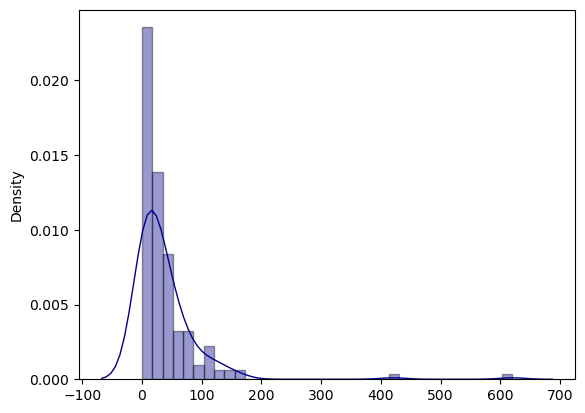

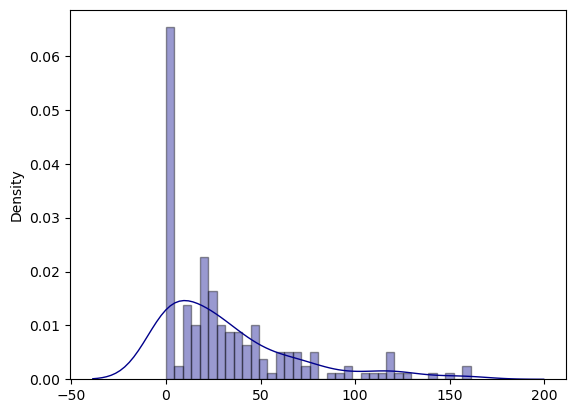

In [3]:
# Sample from full model
psi_prior="normal"
N_samples = 30
N_tuning = 30
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = True
name = "COMMPASS_treat_id_"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running"+name)
idata = sample_from_full_model(X, patient_dictionary, name, N_samples=N_samples, N_tuning=N_tuning, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)
# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [4]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
Seems like chain 2 has not converged in alpha dimension 1 : z_score is 2.474286010338256
Seems like chain 3 has not converged in alpha dimension 1 : z_score is 2.0665052217484816
Seems like chain 0 has not converged in beta_rho_s dimension 1 : z_score is -5.3626776691960565
Seems like chain 0 has not converged in beta_rho_s dimension 2 : z_score is -2.9200724301841934
Seems like chain 0 has not converged in beta_rho_s dimension 3 : z_score is -6.689310781023425
Seems like chain 0 has not converged in beta_rho_s dimension 5 : z_score is -4.755657198999968
Seems like chain 0 has not converged in beta_rho_s dimension 6 : z_score is -6.695037029712283
Seems like chain 0 has not converged in beta_rho_s dimension 8 : z_score is 2.1558978684954866
Seems like chain 0 has not converged in beta_rho_s dimension 11 : z_score is 3.390578455198055
Seems like chain 0 has not converged in beta_rho_s dimension 16 : z_score is 3.217783764813129
Seems like chain 0 has not converged

0

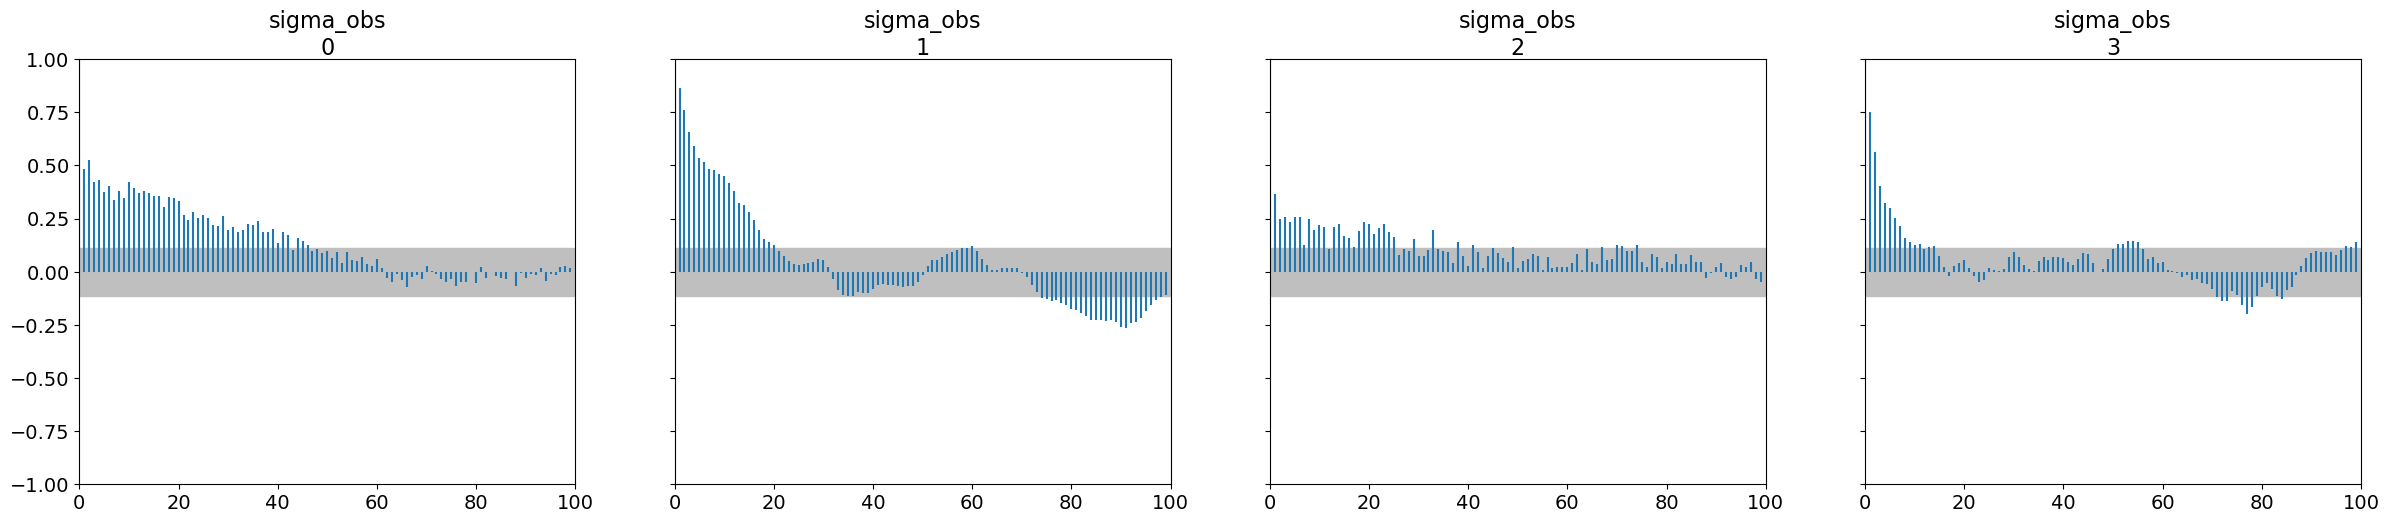

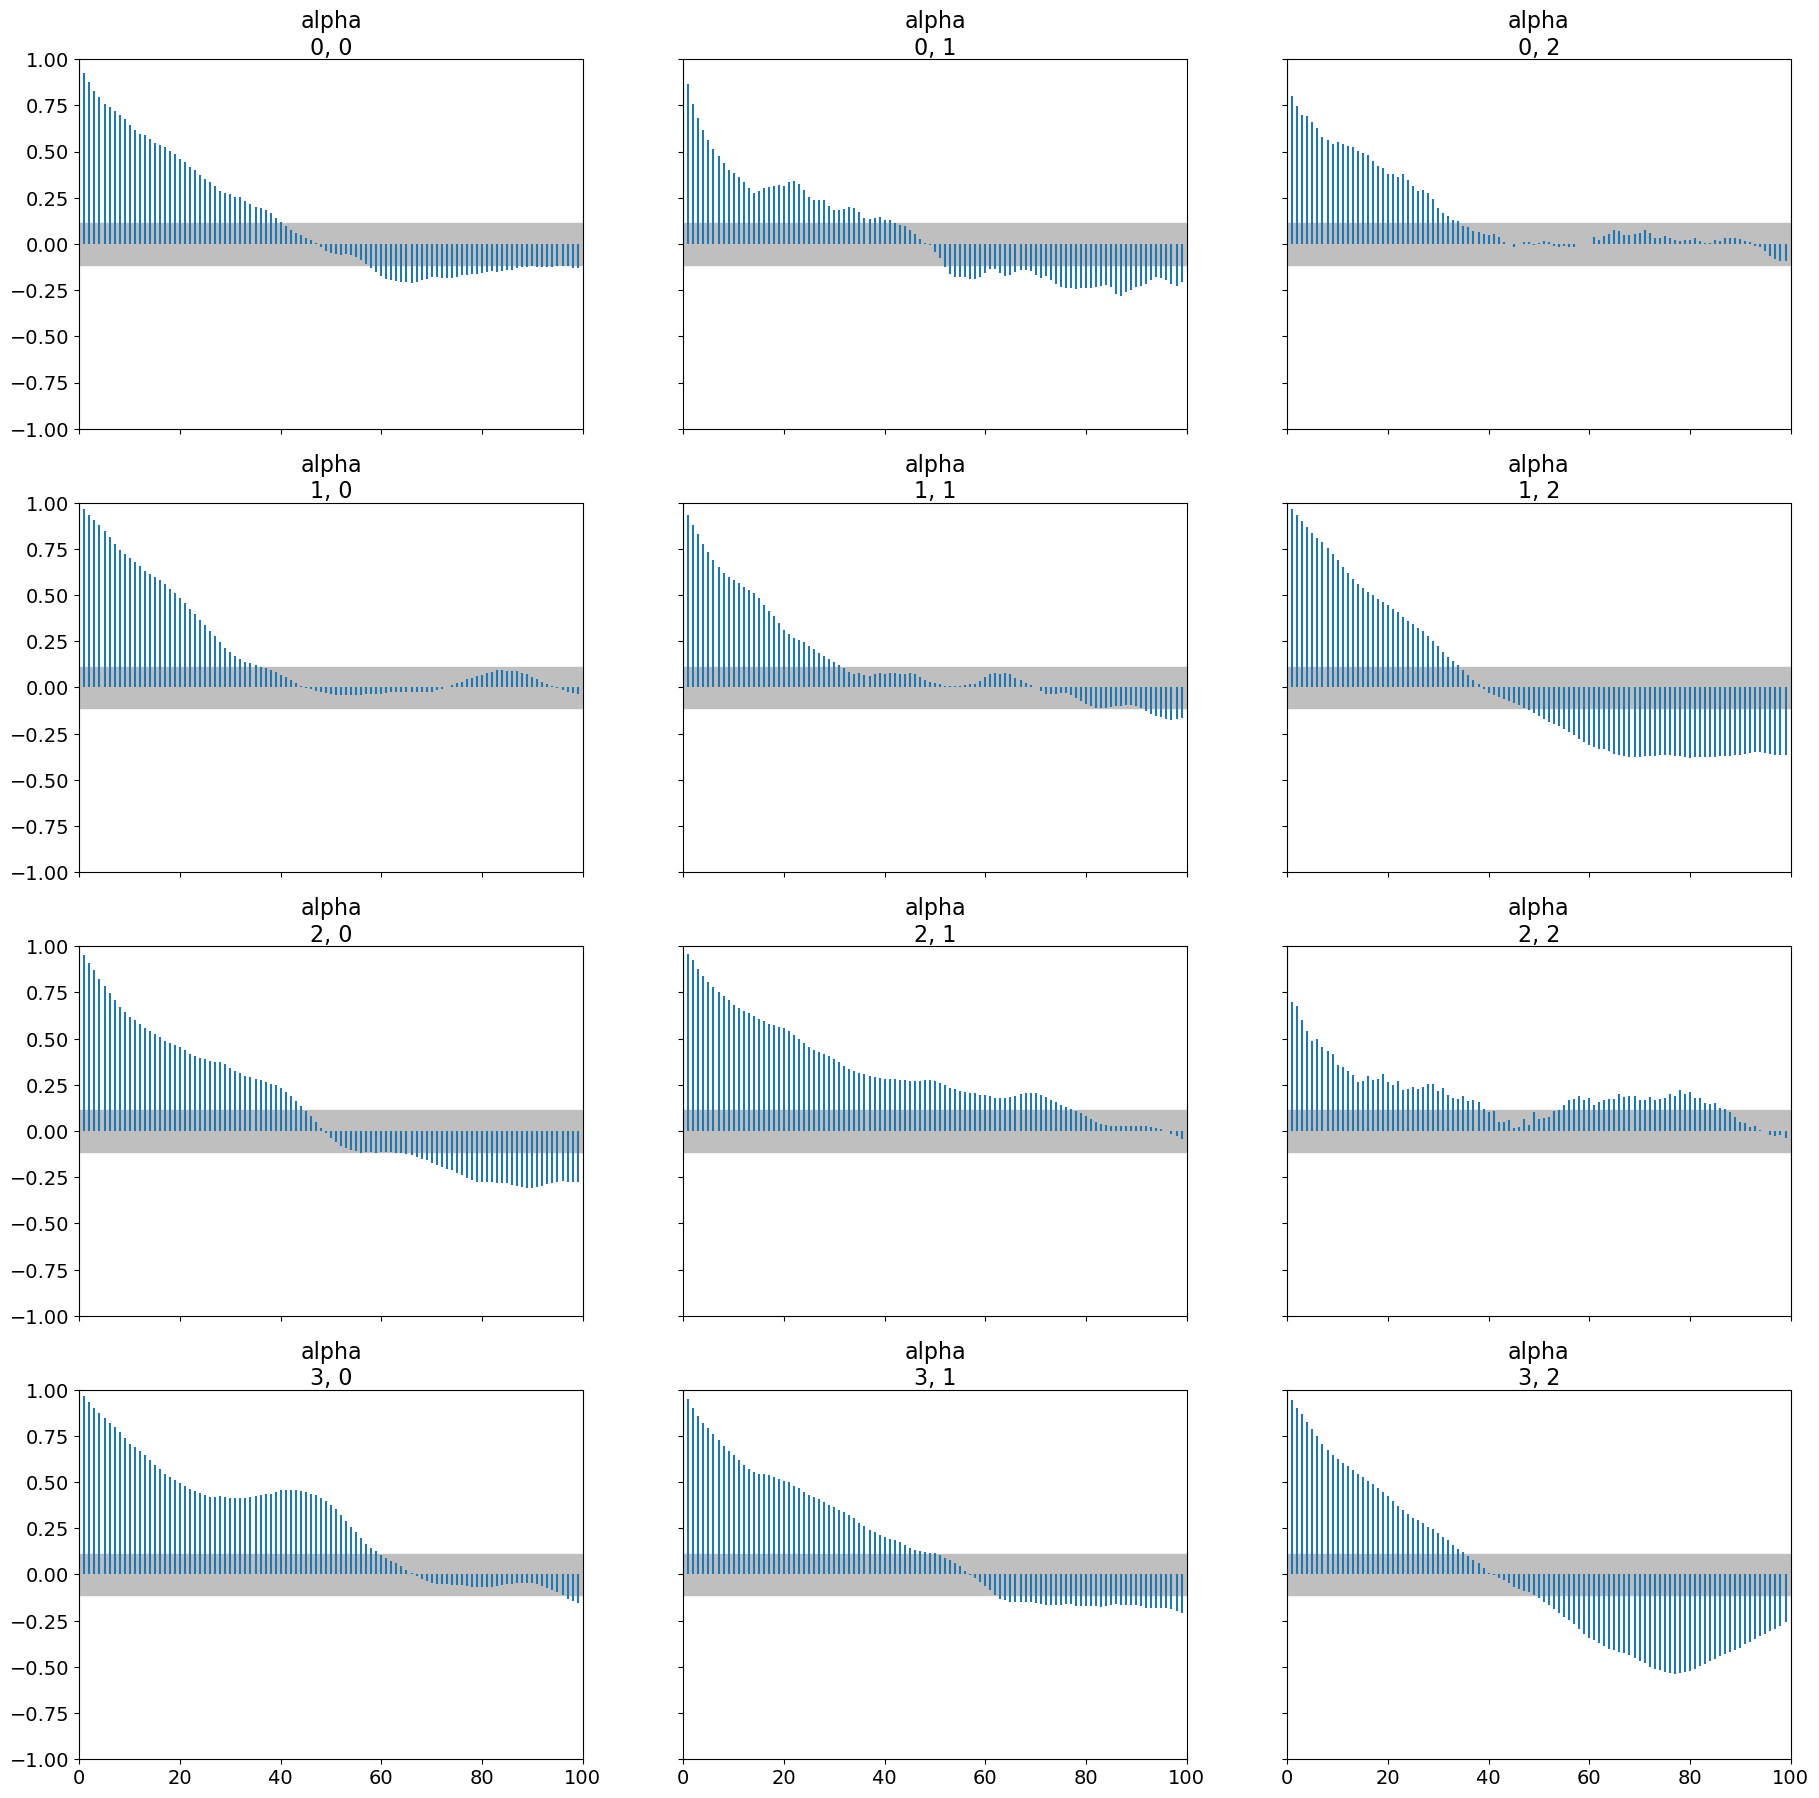

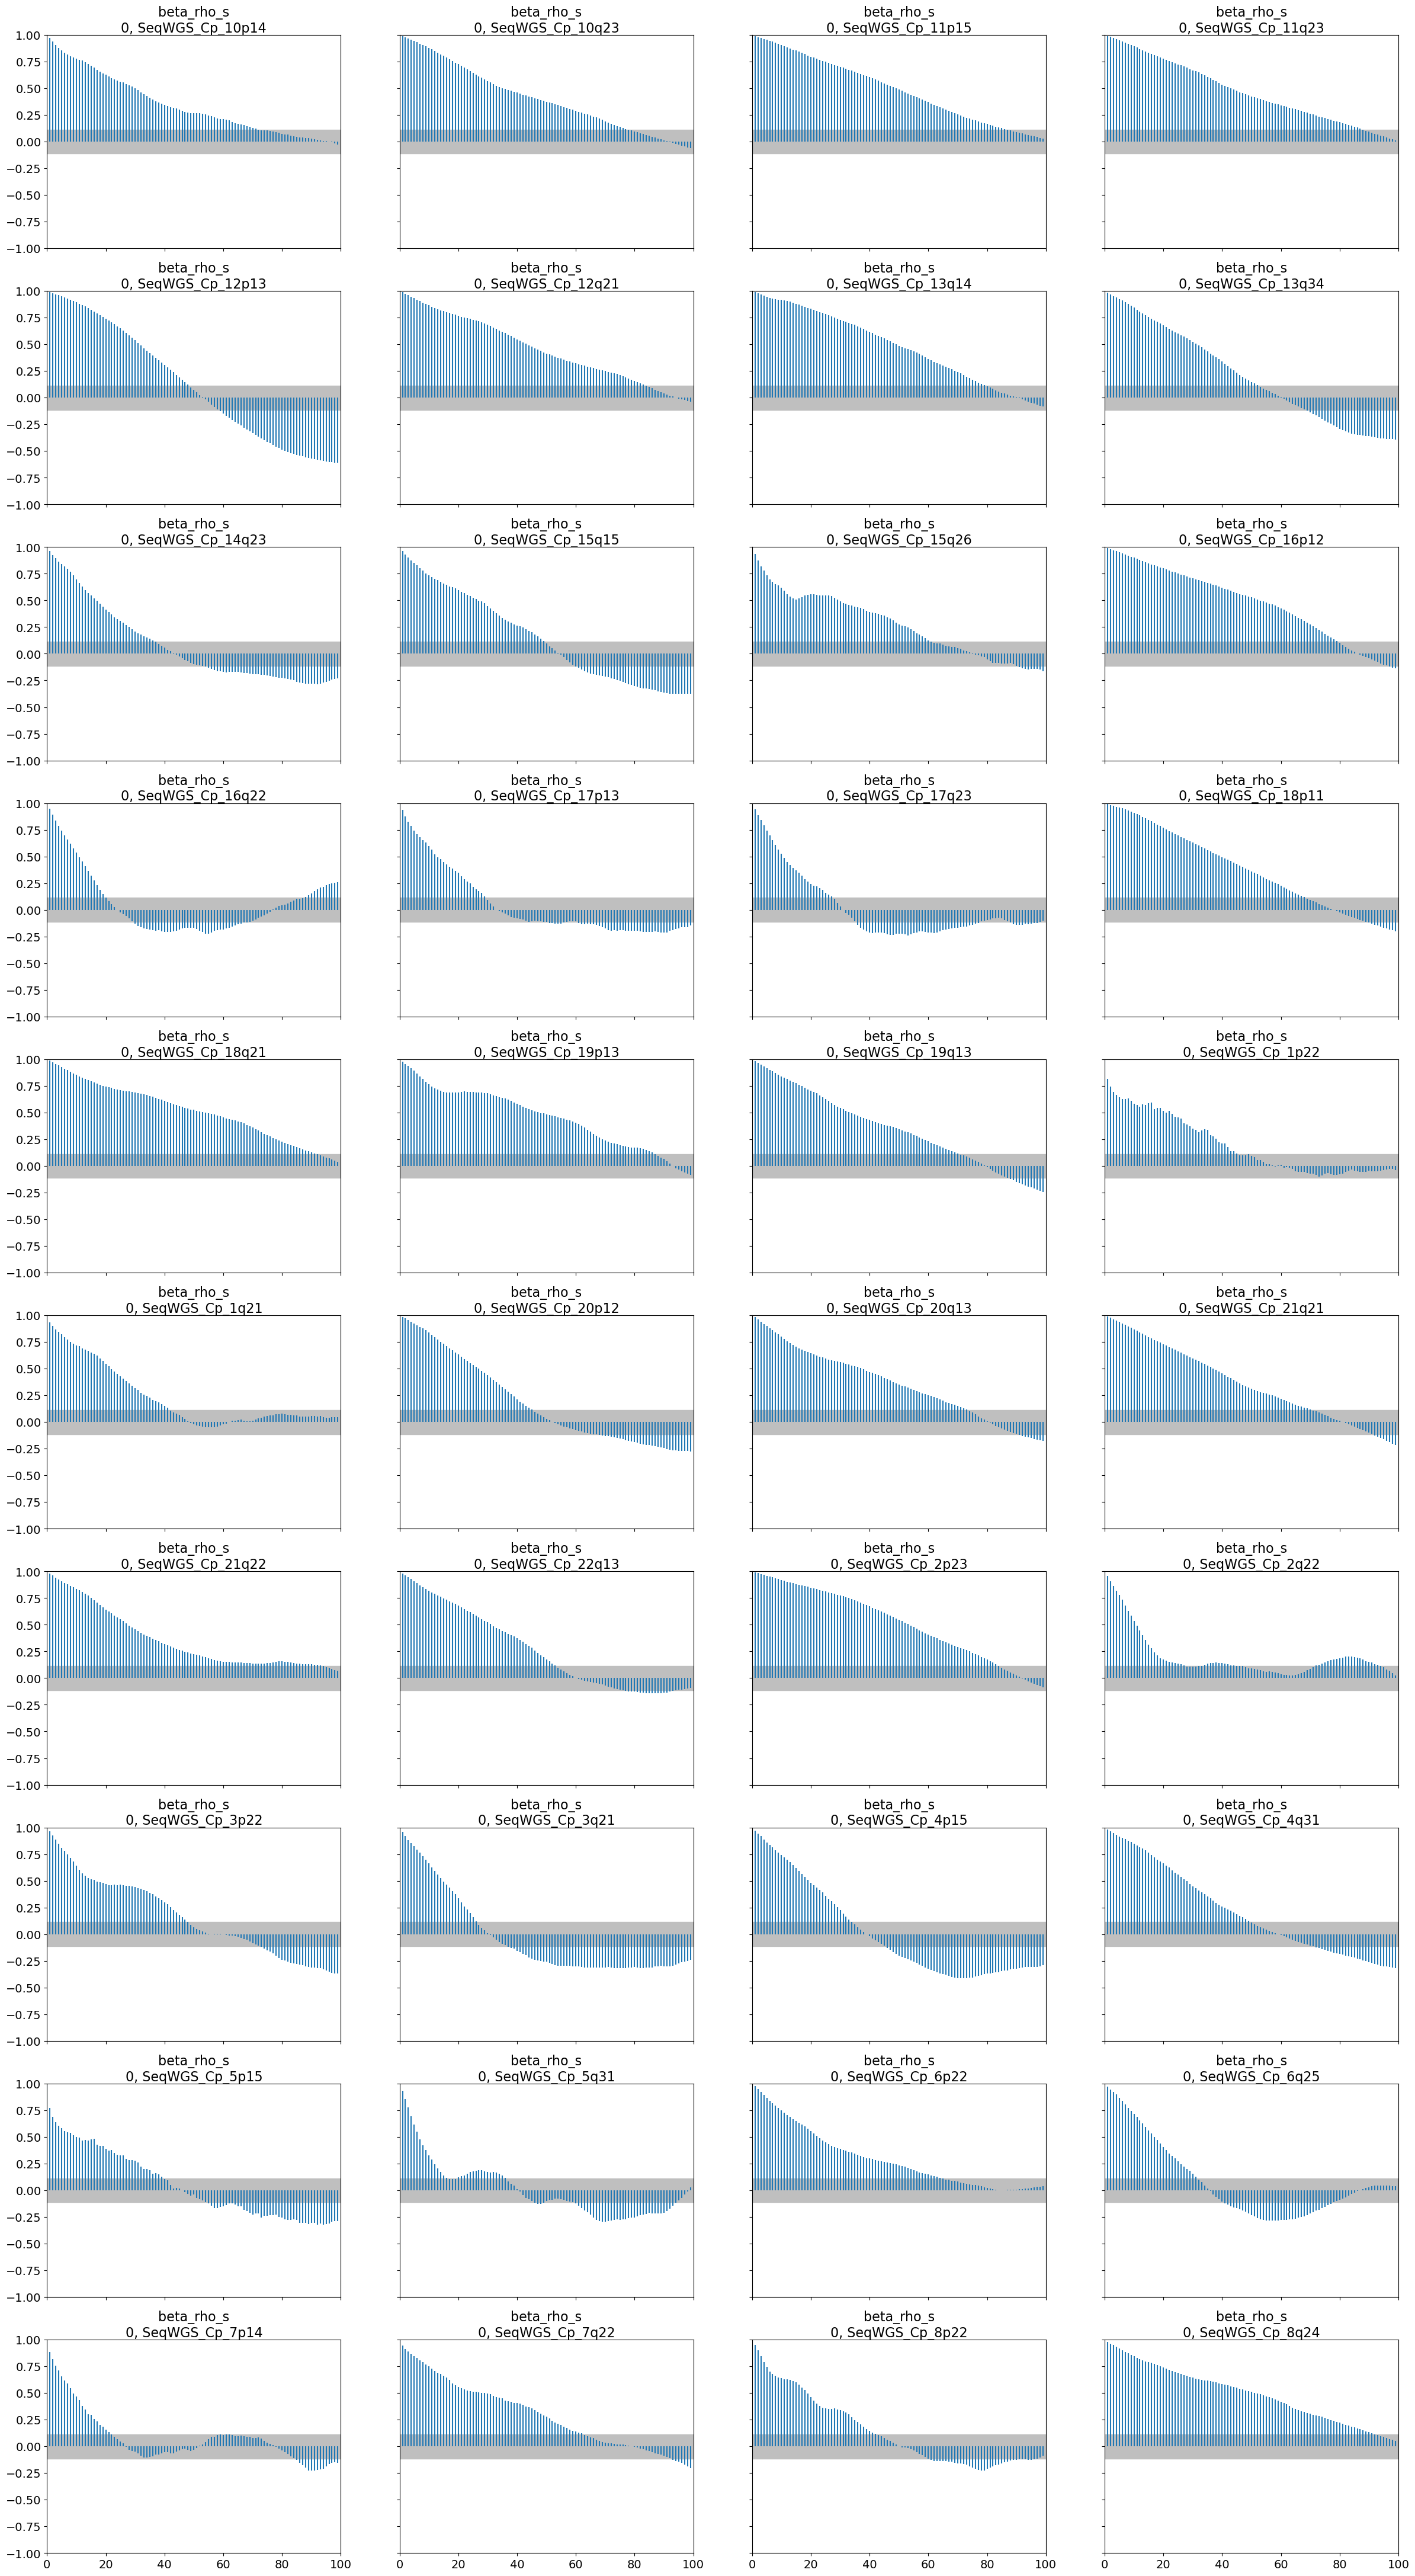

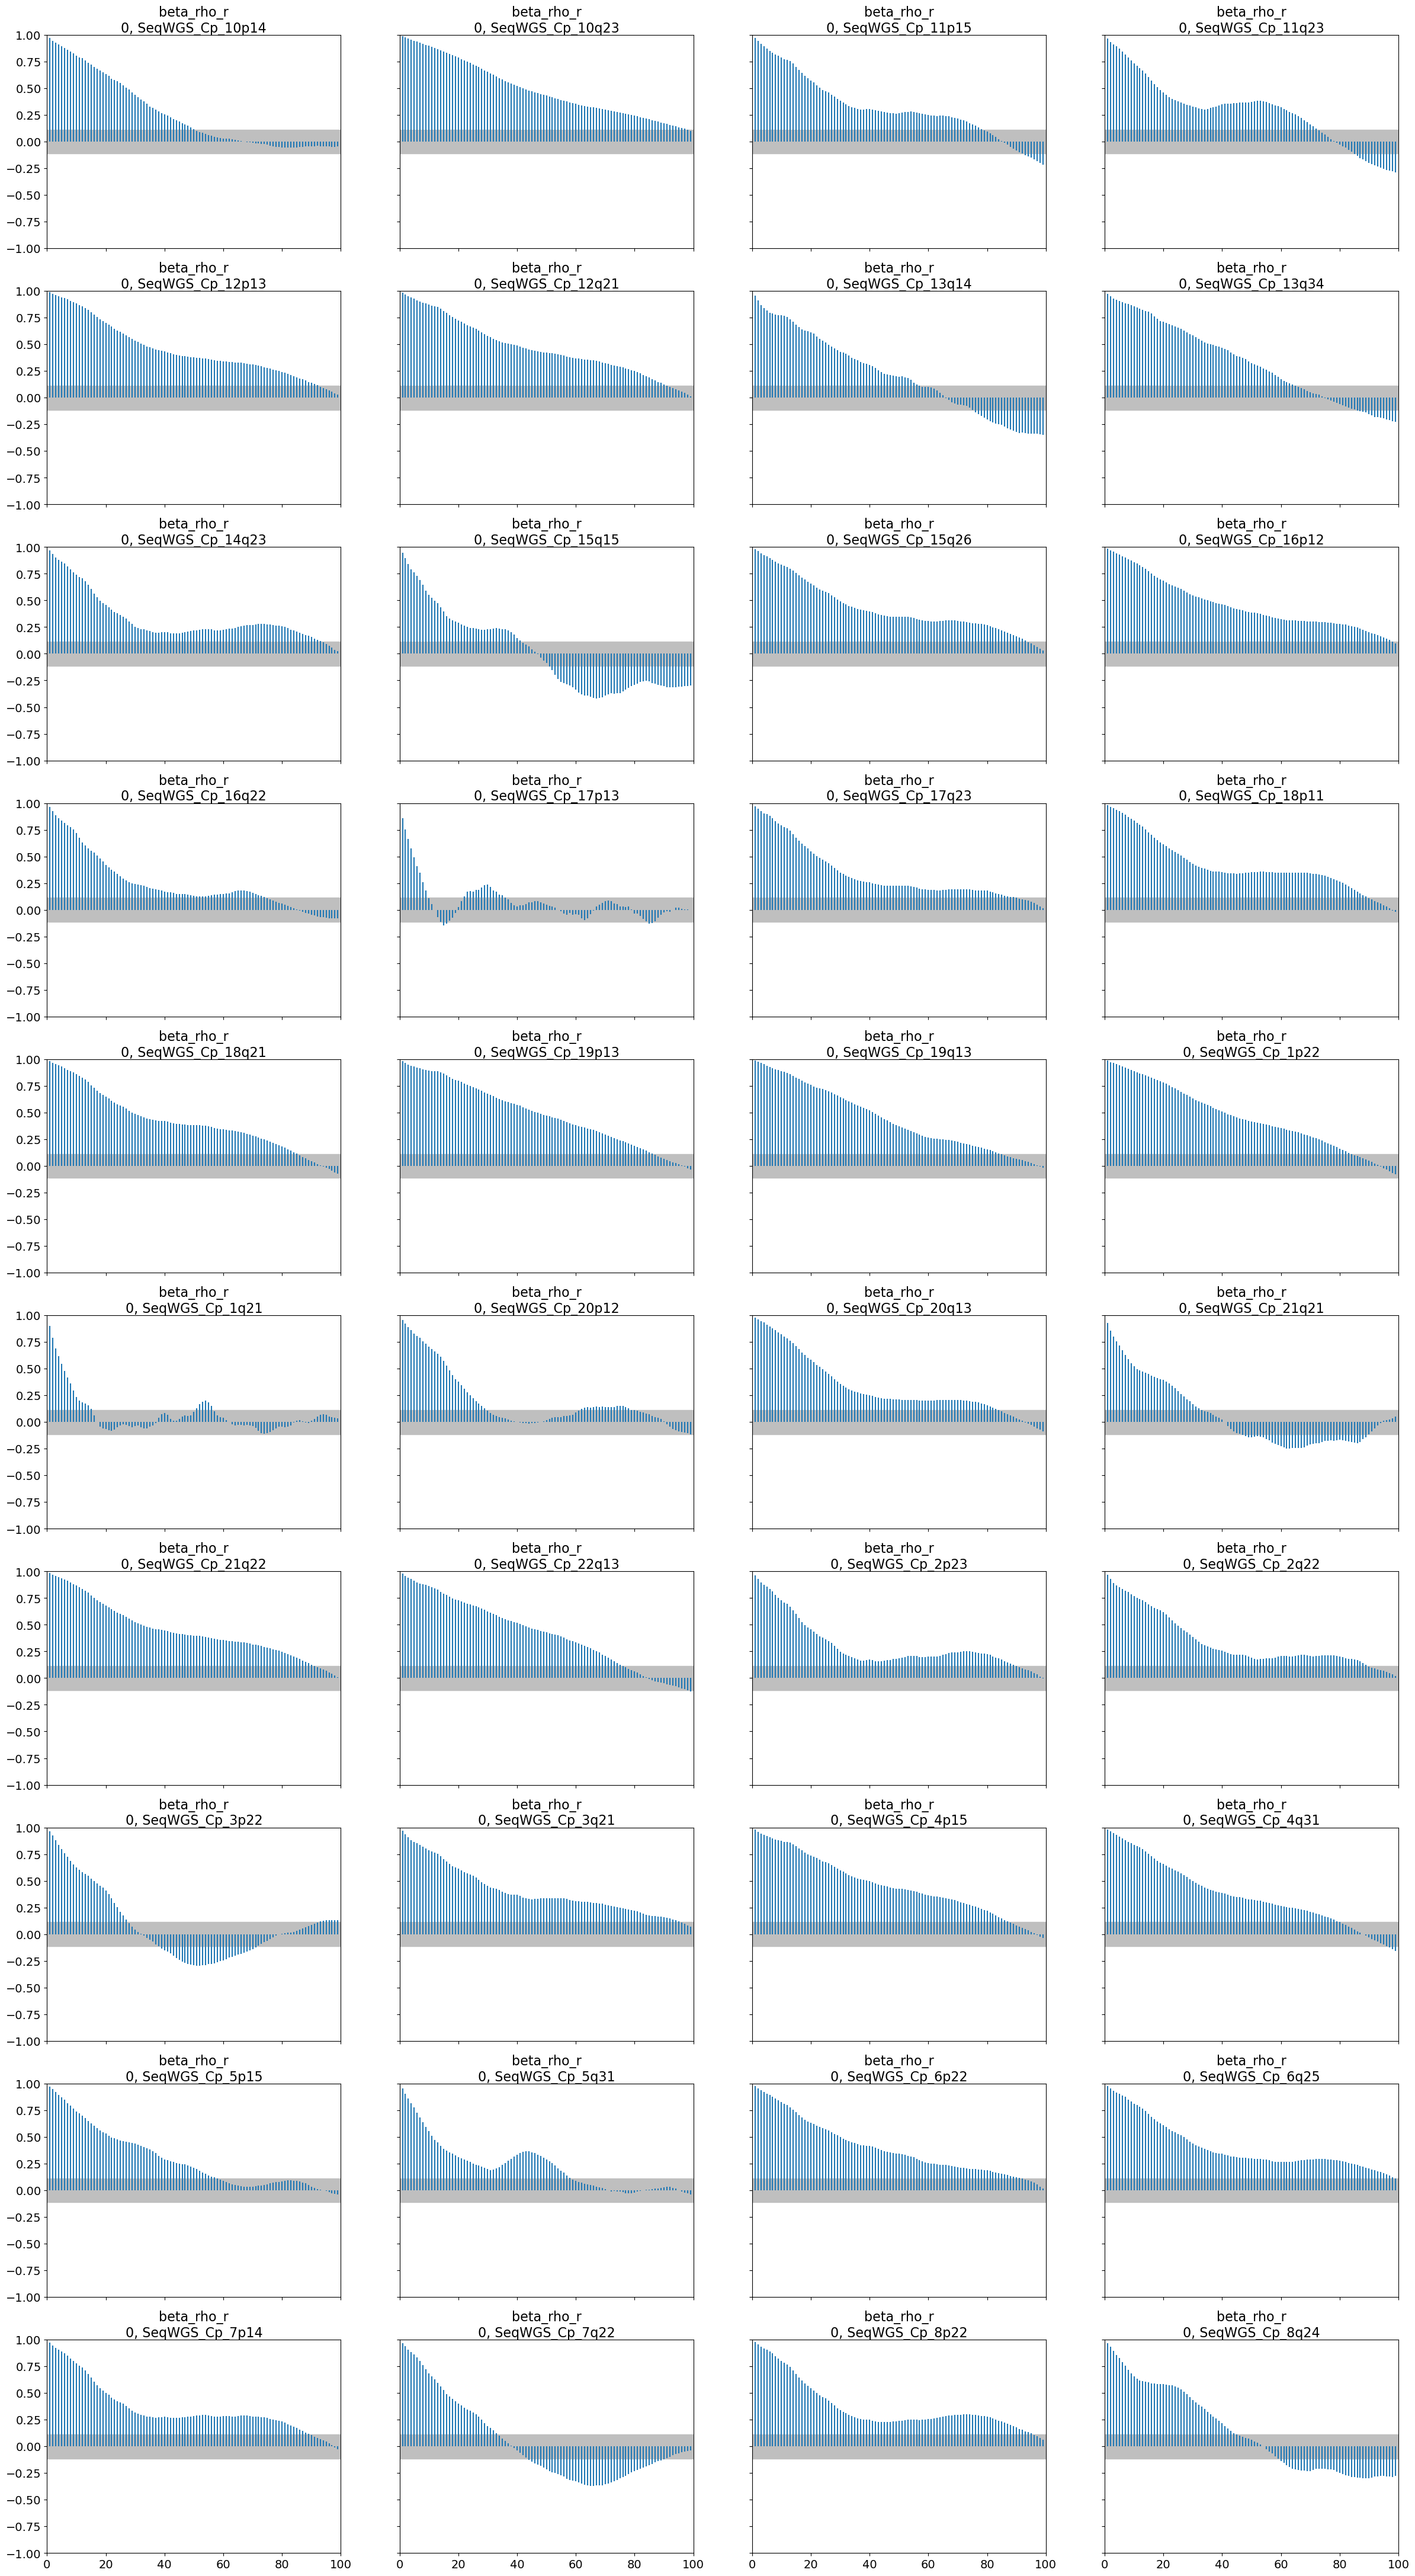

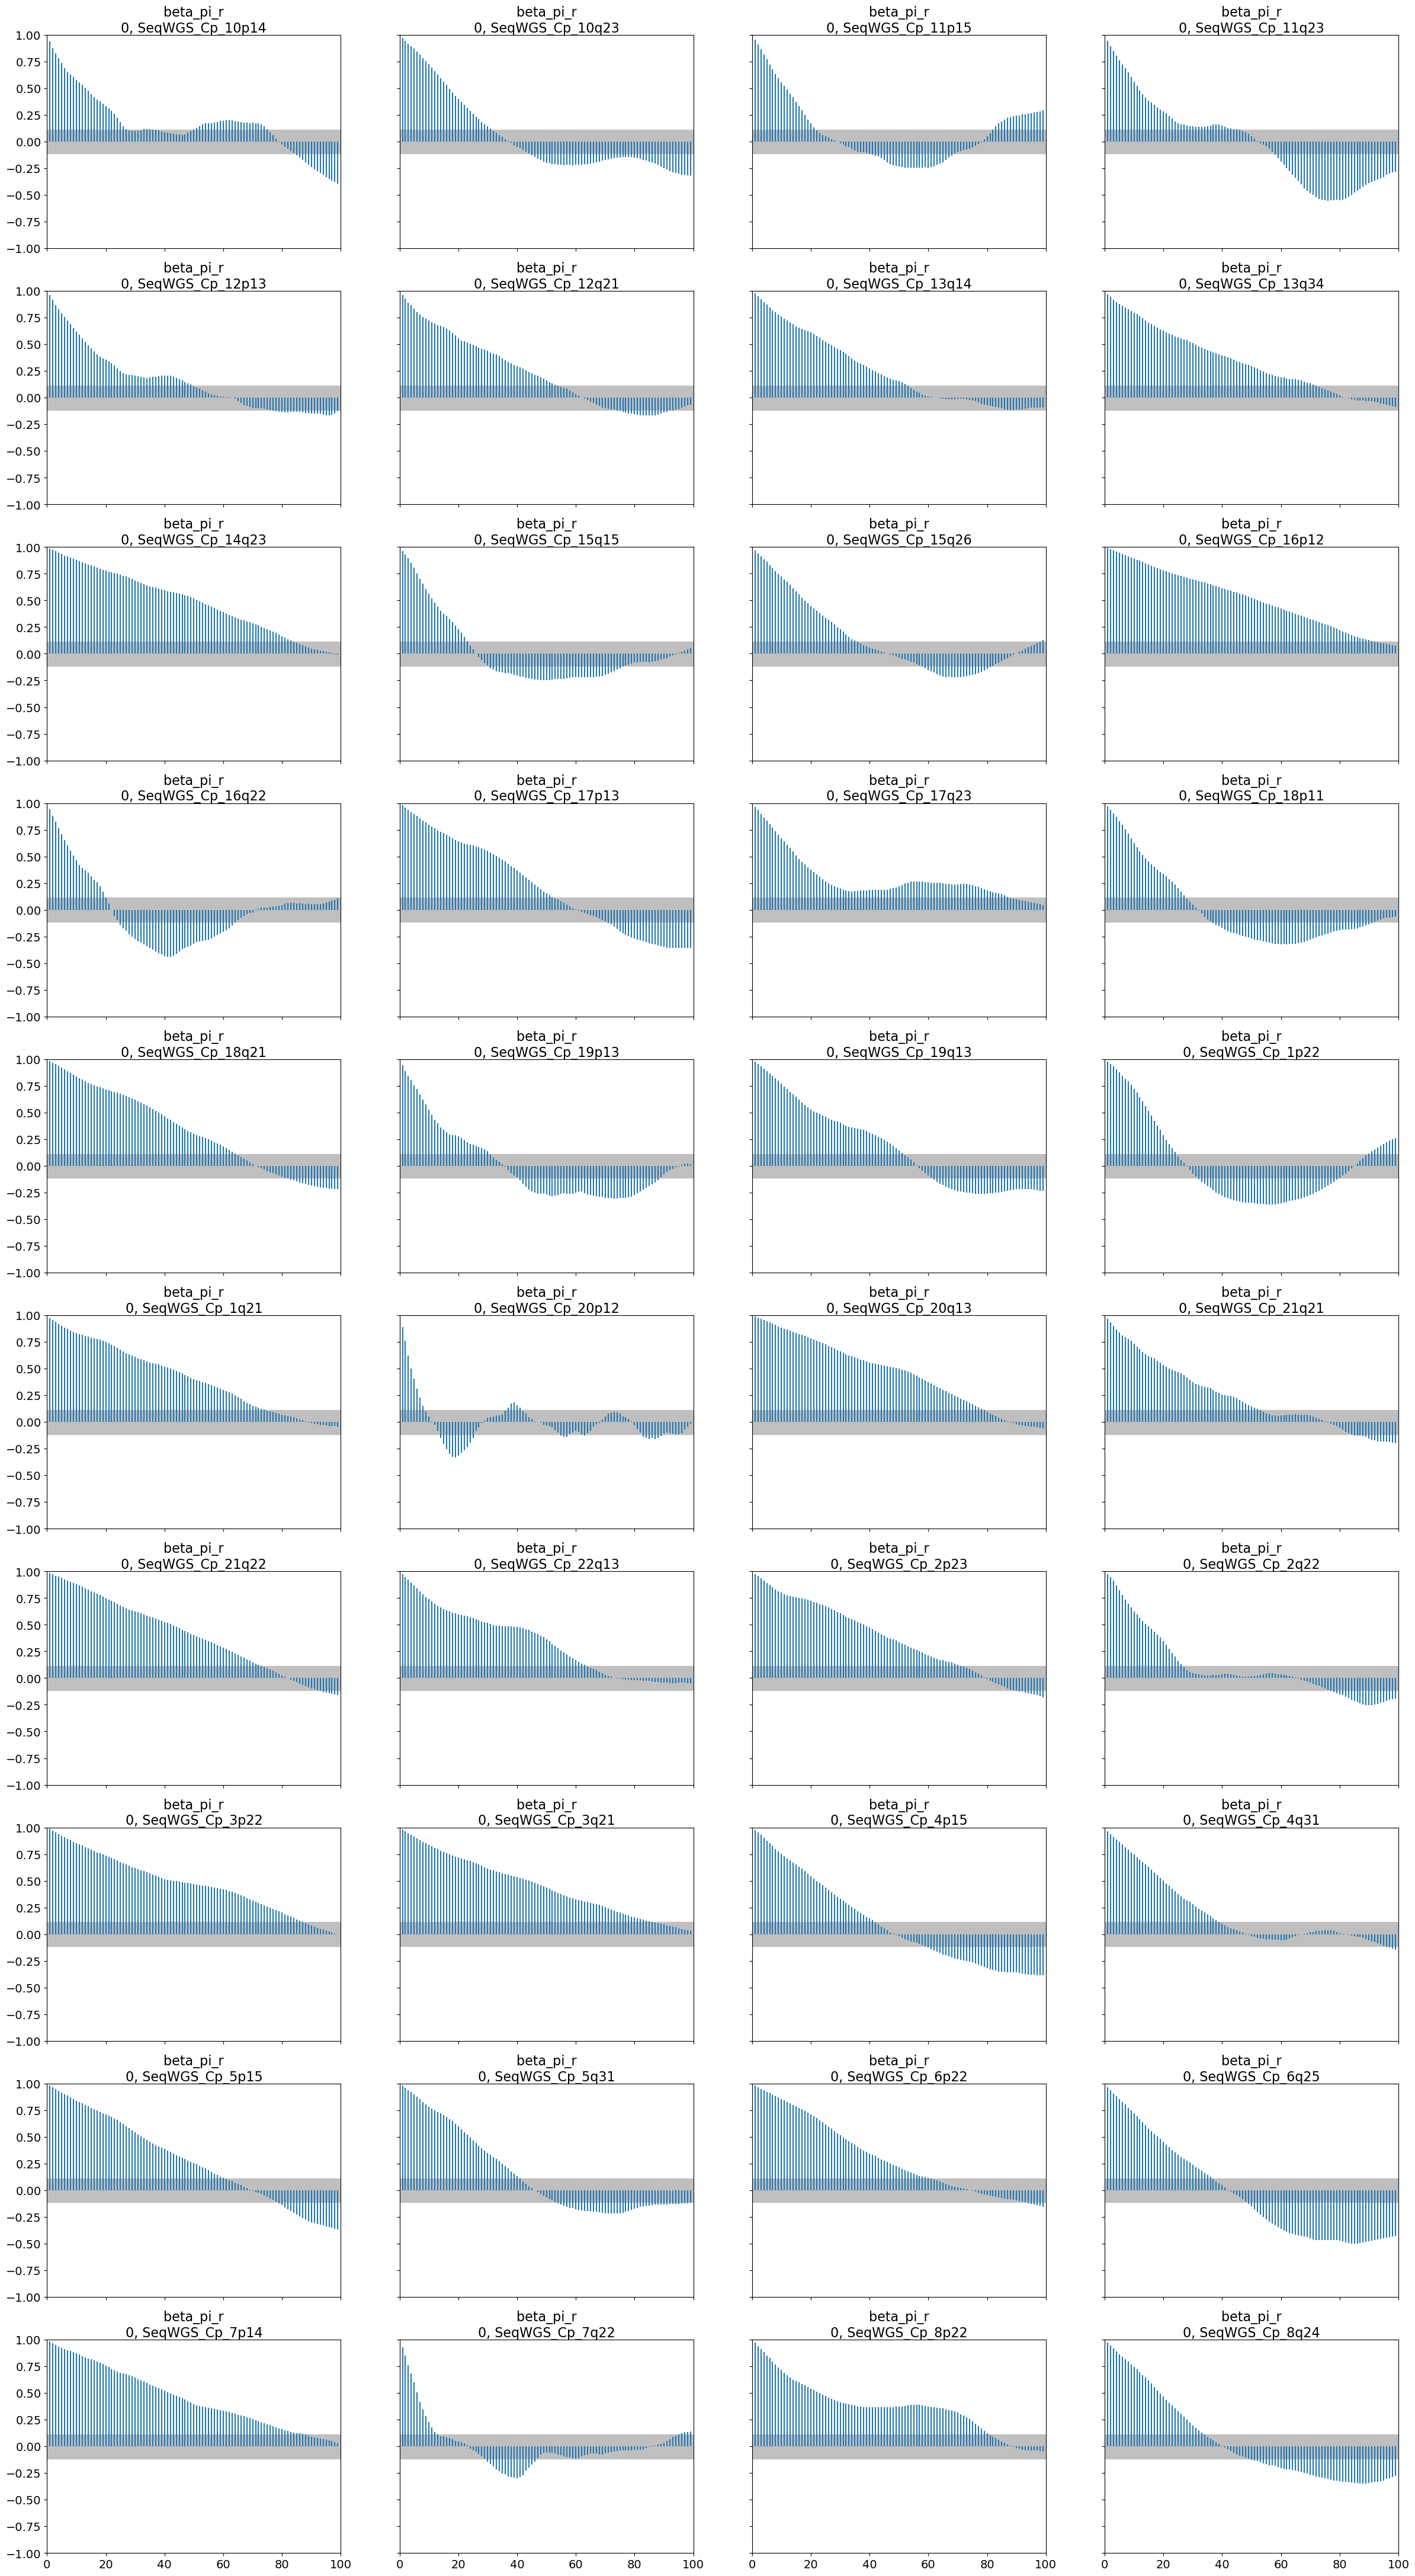

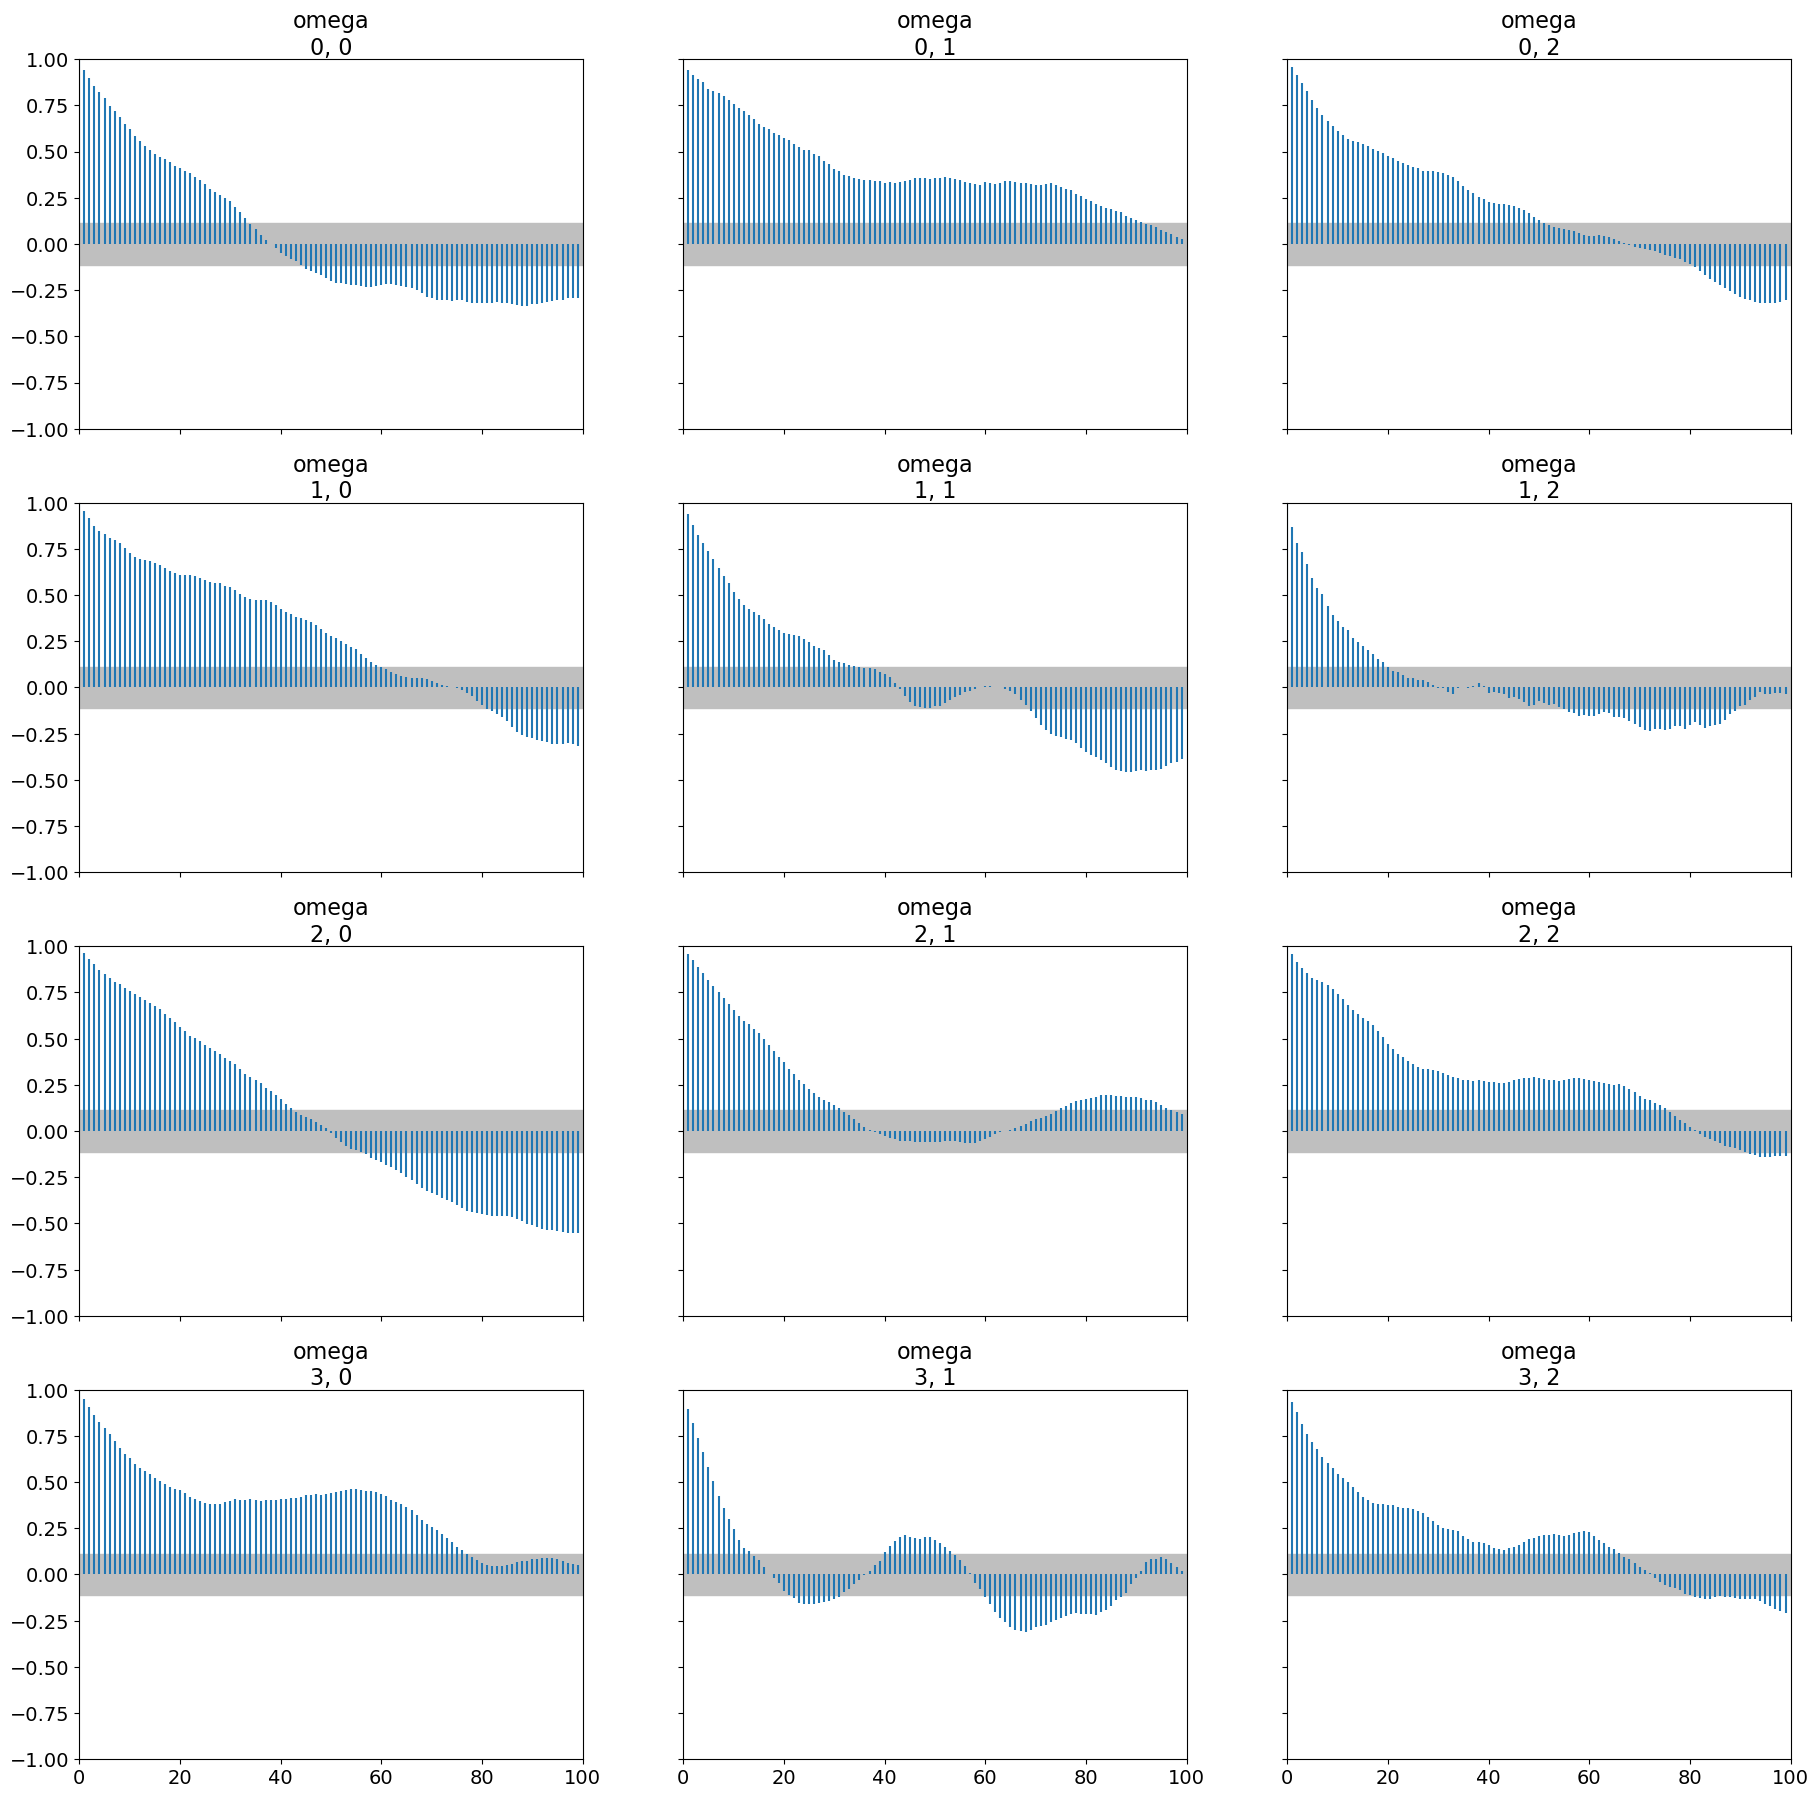

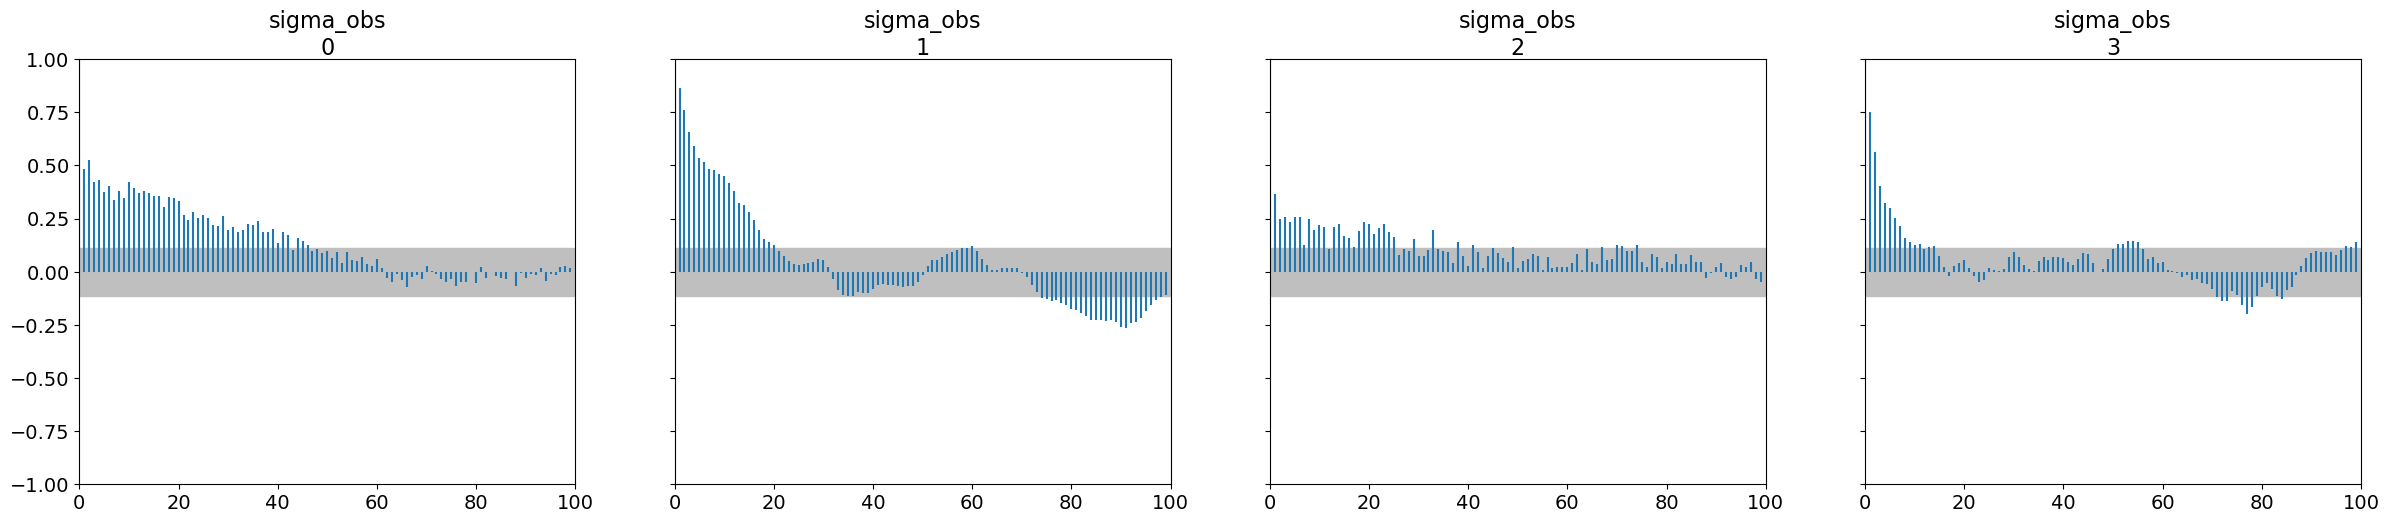

In [6]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
az.plot_autocorr(idata, var_names=["alpha"]);
az.plot_autocorr(idata, var_names=["beta_rho_s"]);
az.plot_autocorr(idata, var_names=["beta_rho_r"]);
az.plot_autocorr(idata, var_names=["beta_pi_r"]);
az.plot_autocorr(idata, var_names=["omega"]);
az.plot_autocorr(idata, var_names=["sigma_obs"]);

In [7]:
# Posterior means 
print("List of covariates:", idata.posterior.coords['predictors'])
print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
print('\nPosterior average of beta_rho_s:\n', np.mean(idata.posterior['beta_rho_s'], axis=(0,1)))
print('\nPosterior average of beta_rho_r:\n', np.mean(idata.posterior['beta_rho_r'], axis=(0,1)))
print('\nPosterior average of beta_pi_r:\n', np.mean(idata.posterior['beta_pi_r'], axis=(0,1)))
print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

List of covariates: <xarray.DataArray 'predictors' (predictors: 164)>
array(['SeqWGS_Cp_10p14', 'SeqWGS_Cp_10q23', 'SeqWGS_Cp_11p15',
       'SeqWGS_Cp_11q23', 'SeqWGS_Cp_12p13', 'SeqWGS_Cp_12q21',
       'SeqWGS_Cp_13q14', 'SeqWGS_Cp_13q34', 'SeqWGS_Cp_14q23',
       'SeqWGS_Cp_15q15', 'SeqWGS_Cp_15q26', 'SeqWGS_Cp_16p12',
       'SeqWGS_Cp_16q22', 'SeqWGS_Cp_17p13', 'SeqWGS_Cp_17q23',
       'SeqWGS_Cp_18p11', 'SeqWGS_Cp_18q21', 'SeqWGS_Cp_19p13',
       'SeqWGS_Cp_19q13', 'SeqWGS_Cp_1p22', 'SeqWGS_Cp_1q21',
       'SeqWGS_Cp_20p12', 'SeqWGS_Cp_20q13', 'SeqWGS_Cp_21q21',
       'SeqWGS_Cp_21q22', 'SeqWGS_Cp_22q13', 'SeqWGS_Cp_2p23',
       'SeqWGS_Cp_2q22', 'SeqWGS_Cp_3p22', 'SeqWGS_Cp_3q21', 'SeqWGS_Cp_4p15',
       'SeqWGS_Cp_4q31', 'SeqWGS_Cp_5p15', 'SeqWGS_Cp_5q31', 'SeqWGS_Cp_6p22',
       'SeqWGS_Cp_6q25', 'SeqWGS_Cp_7p14', 'SeqWGS_Cp_7q22', 'SeqWGS_Cp_8p22',
       'SeqWGS_Cp_8q24', 'SeqWGS_Cp_9p13', 'SeqWGS_Cp_9q33', 'SeqWGS_Cp_BIRCs',
       'SeqWGS_Cp_CDKN2C', 'SeqWGS_Cp_CY

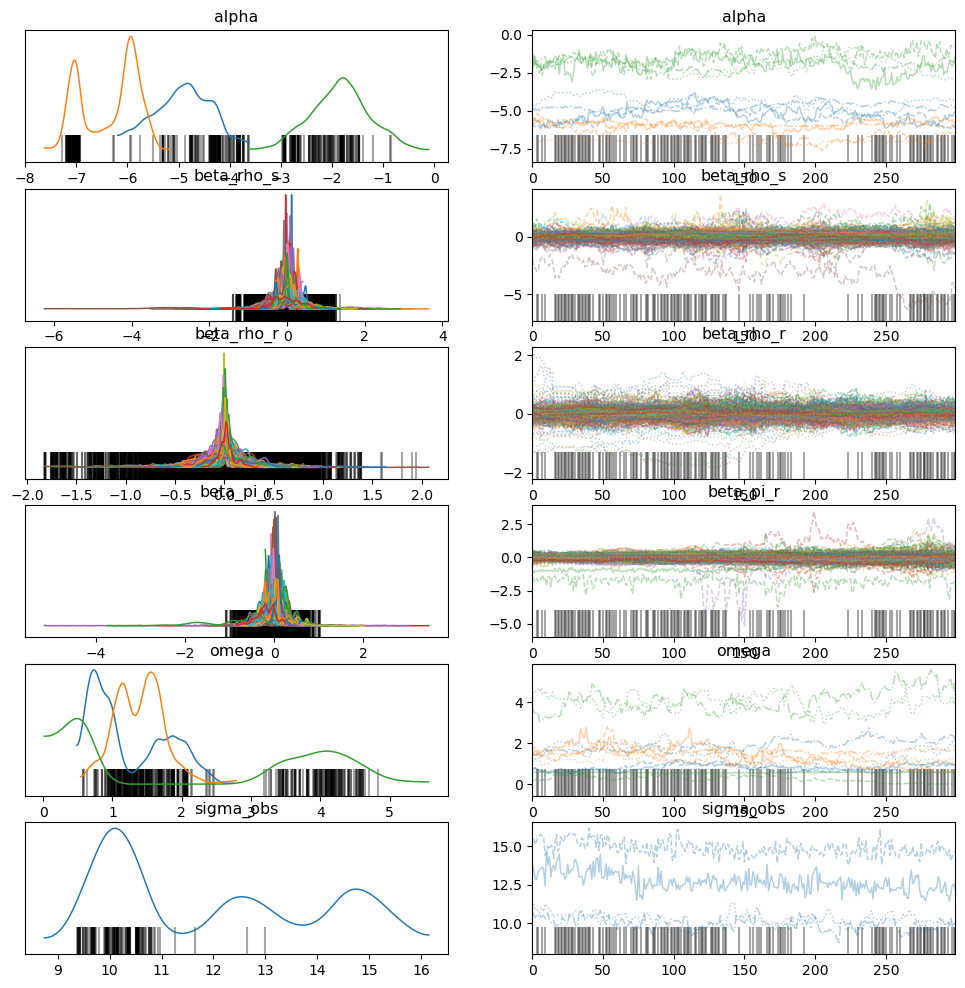

In [8]:
az.plot_trace(idata, var_names=('alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

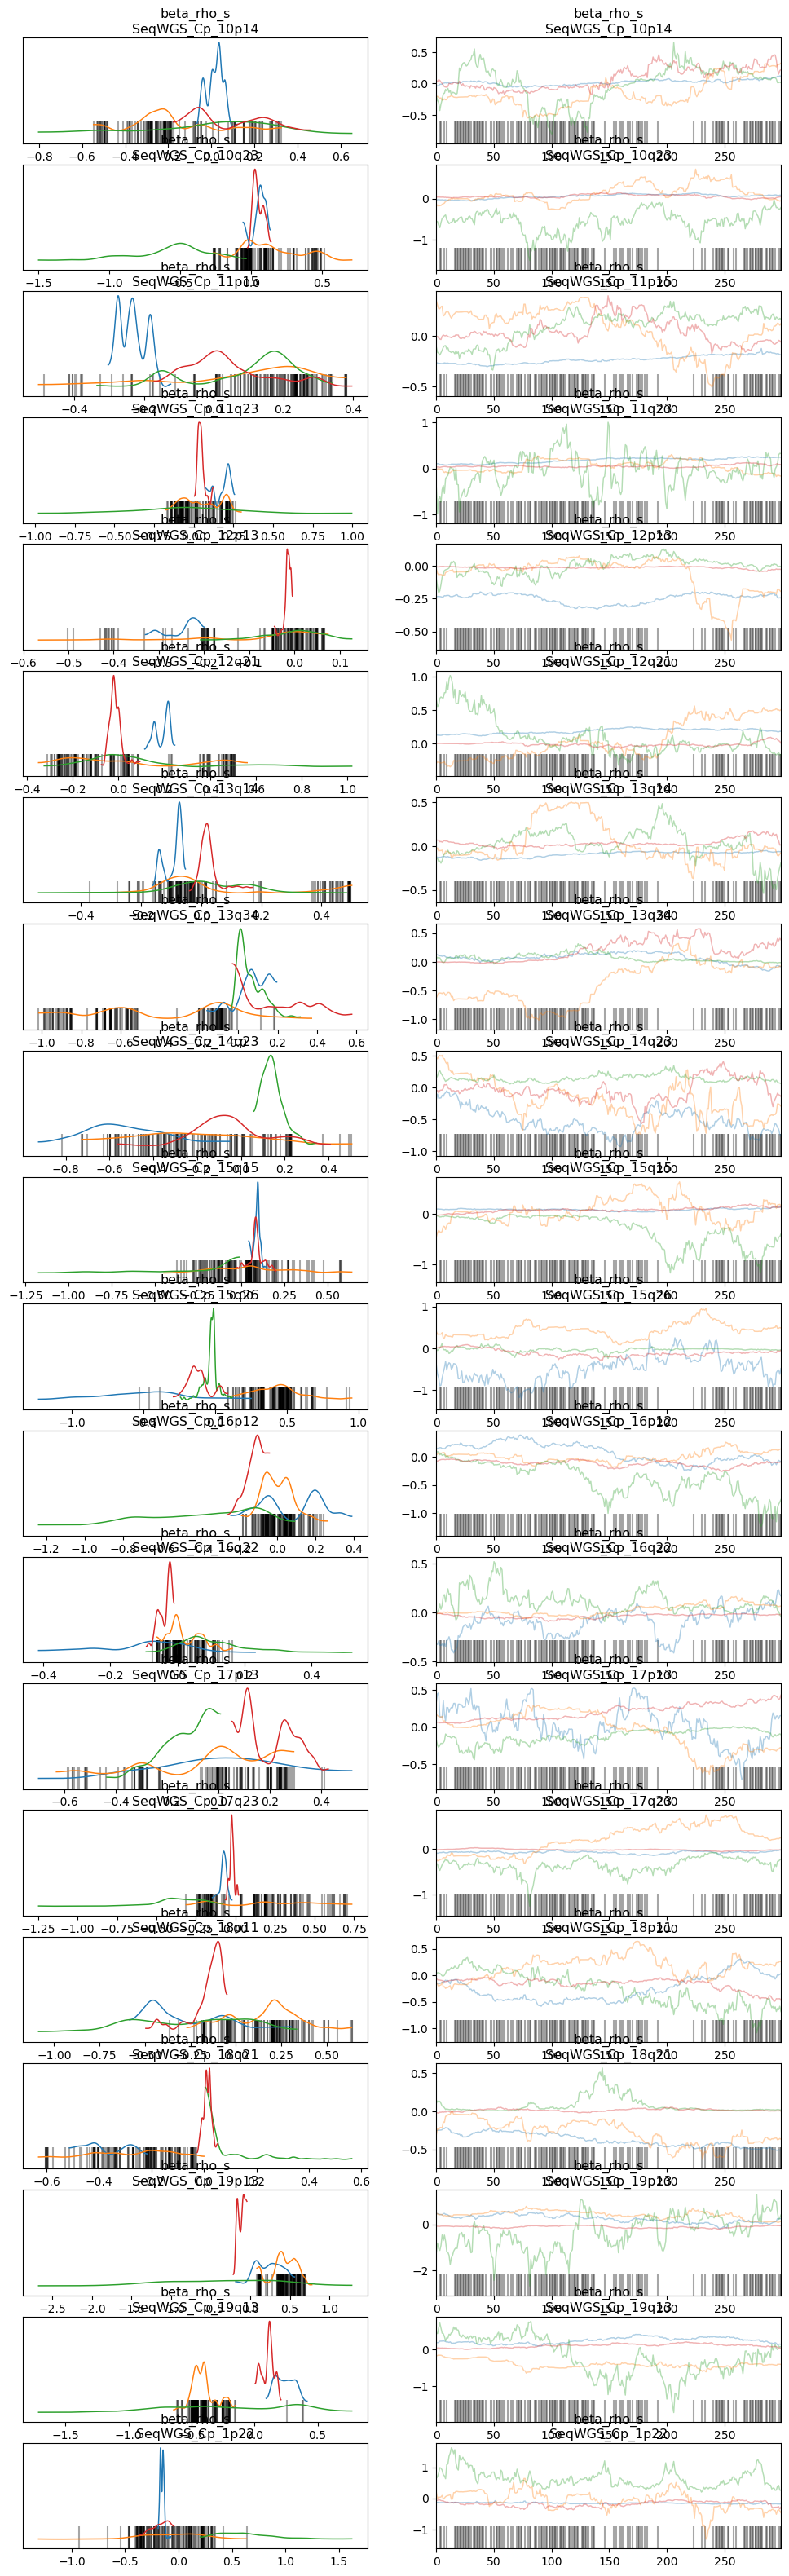

In [9]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_s'), lines=[('beta_rho_s', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_s.png")
# There seems to be an effect where Age contributes towards higher growth rate for sensitive cells

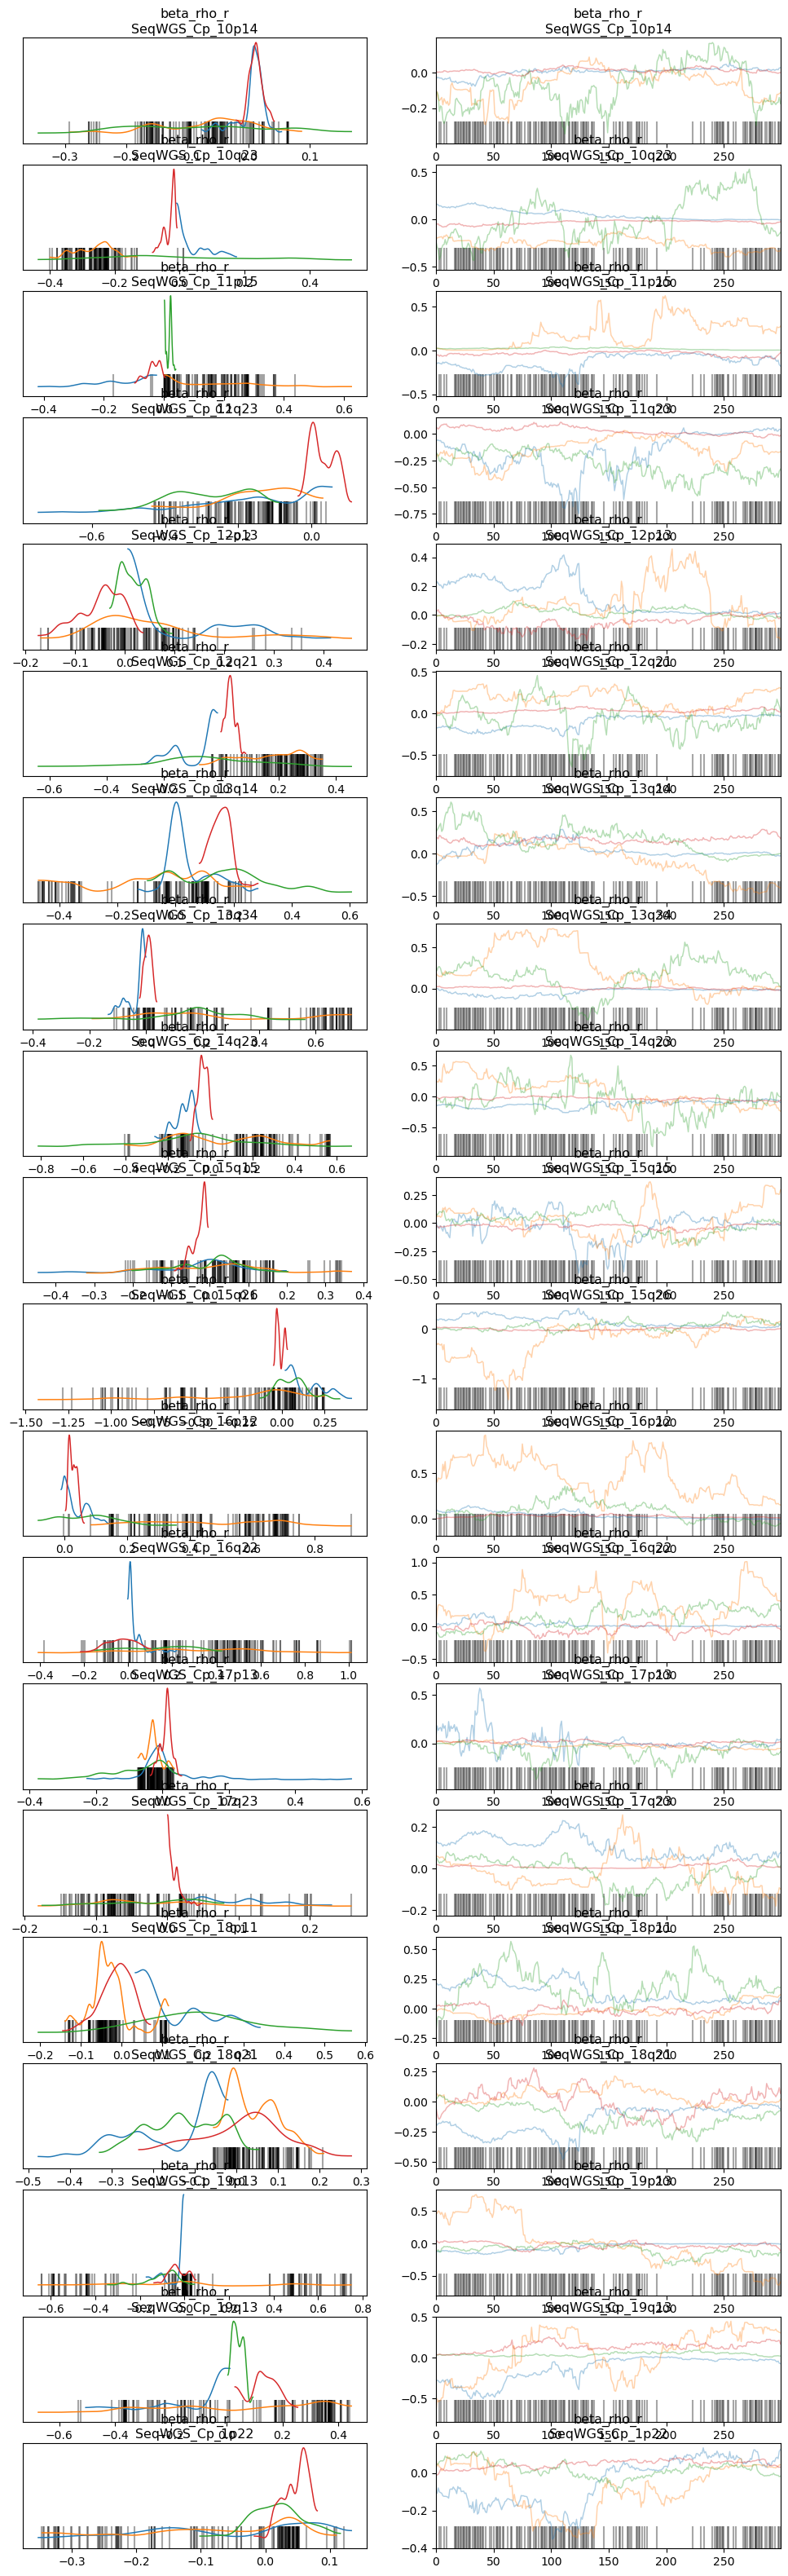

In [10]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_r'), lines=[('beta_rho_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_r.png")

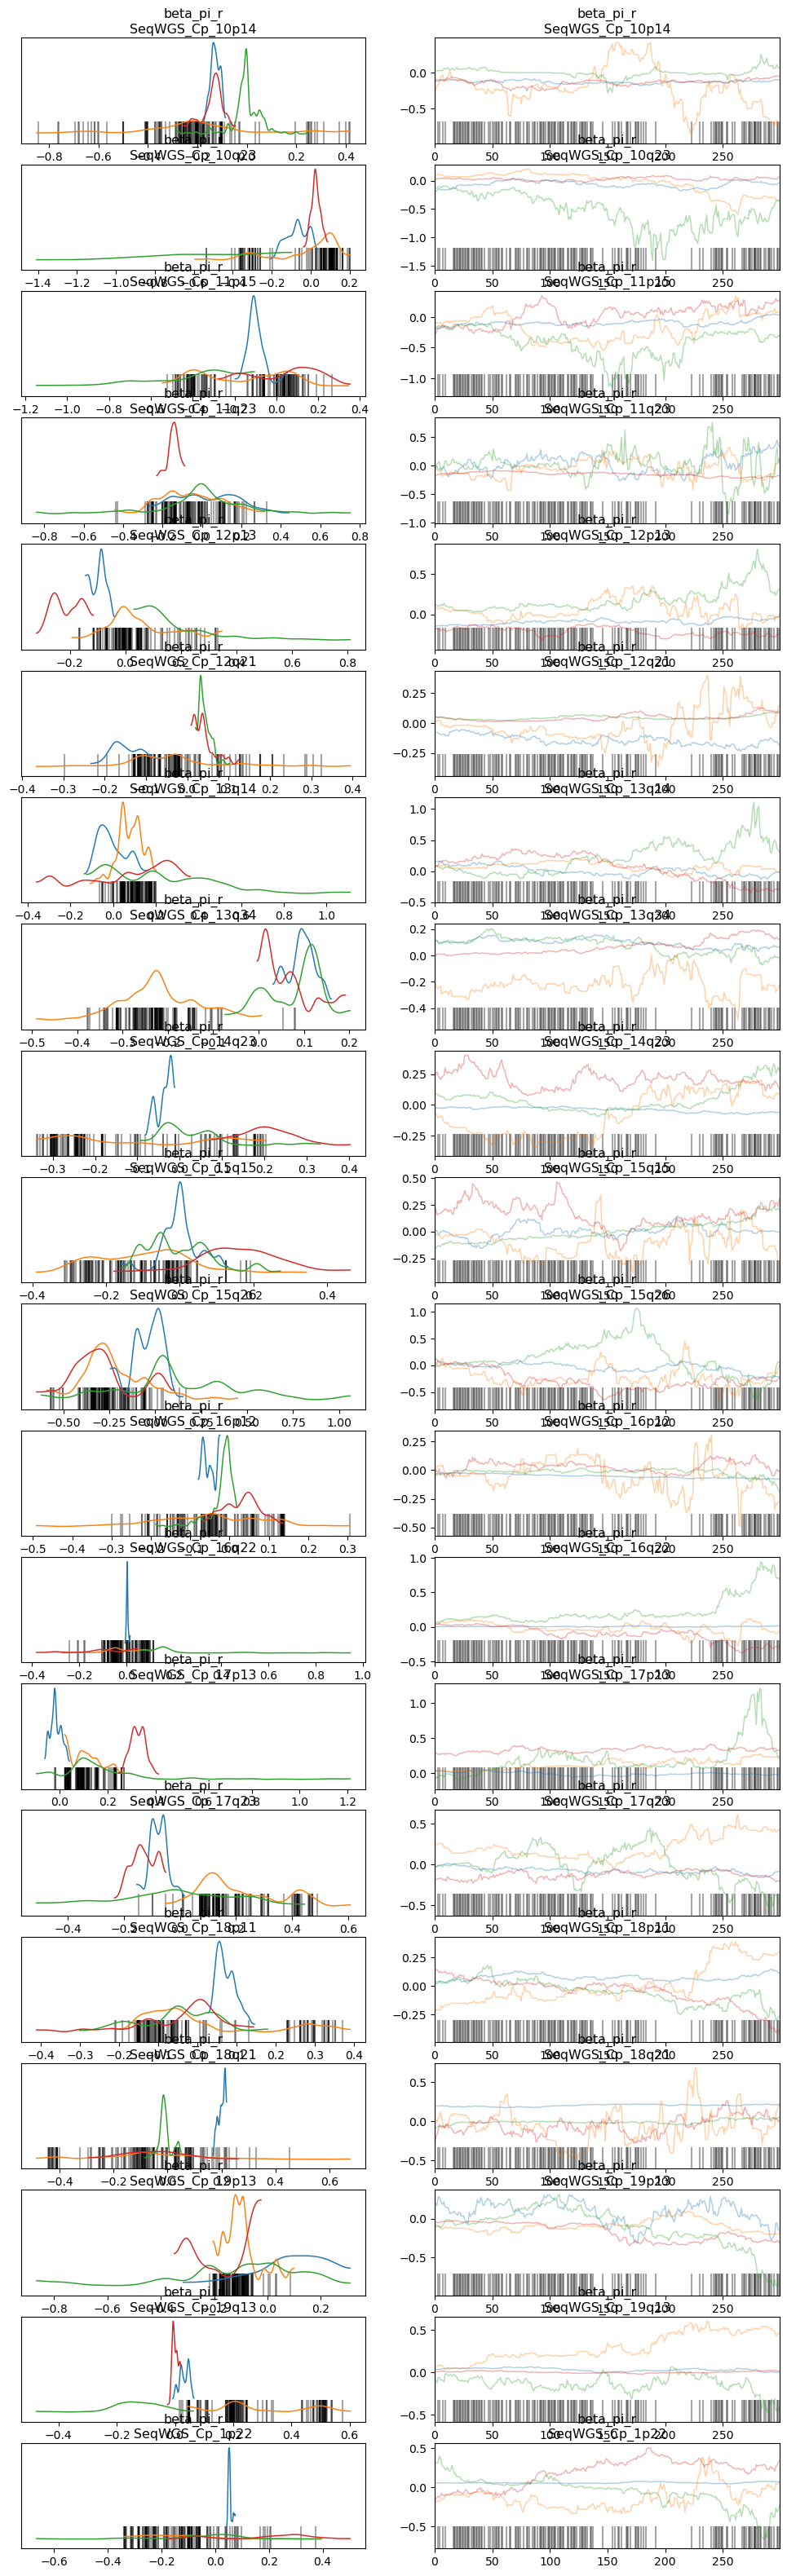

In [11]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_pi_r'), lines=[('beta_pi_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.

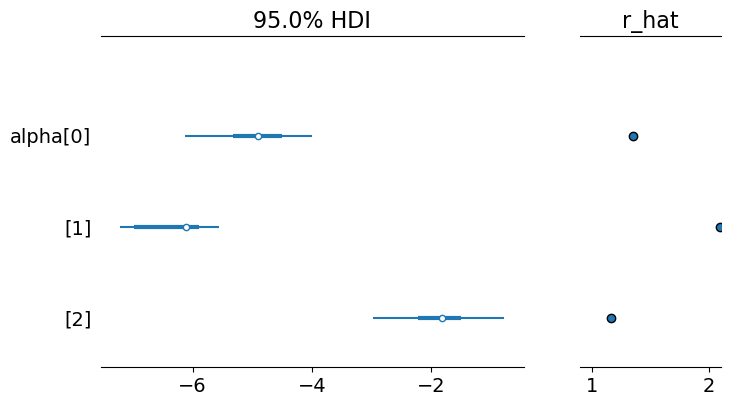

In [12]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
az.plot_energy(idata)
plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["beta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["beta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["beta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_pi_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [54]:
# Posterior distribution of y values
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2]
# Gather all the parameter estimates and get y values for each parameter set
posterior_parameters = np.empty(shape=sample_shape, dtype=object)
y_resolution = 1000
predicted_y_values = np.empty((sample_shape+(y_resolution,)))
predicted_y_resistant_values = np.empty_like(predicted_y_values)
for ii in range(var_dimensions): # per patient
    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times()
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa,ii] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa,ii]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            meas = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            predicted_y_values[ch,sa,ii] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa,ii] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)


In [67]:
print(predicted_y_values[0,0,0].shape)
print(predicted_y_resistant_values[0,0,0].shape)

# Group measurements by patient and time
flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,var_dims,1000))
# sort the arrays of y
sorted_pred_y_values = np.sort(flat_pred_y_values, axis=0)
print(sorted_pred_y_values.shape)

(1000,)
(1000,)
(1200, 30, 1000)
(30, 1000)


In [ ]:
plot_true_mprotein_with_observations_and_treatments_and_estimate(parameter_estimates, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Patient 1", savename=0):


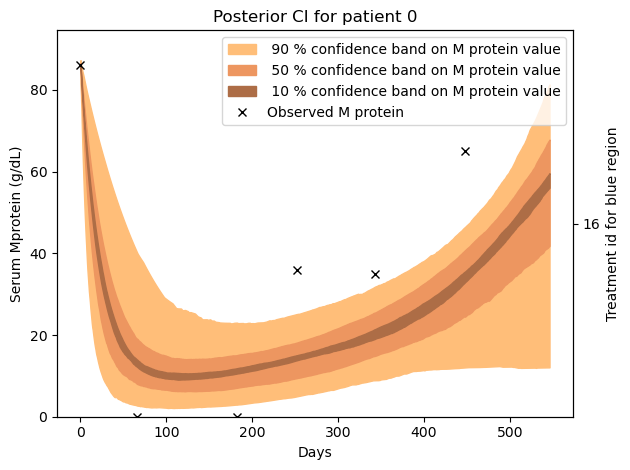

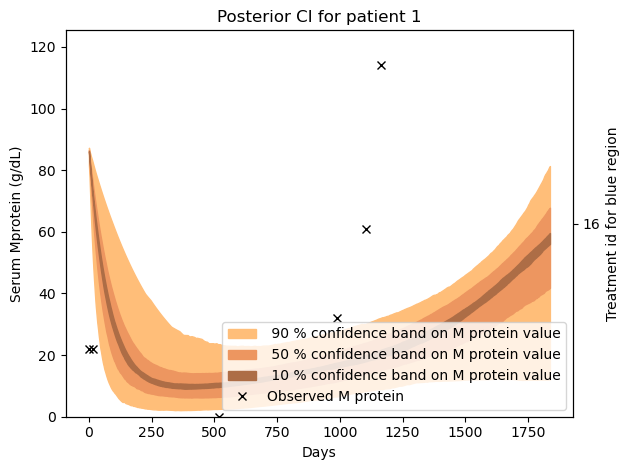

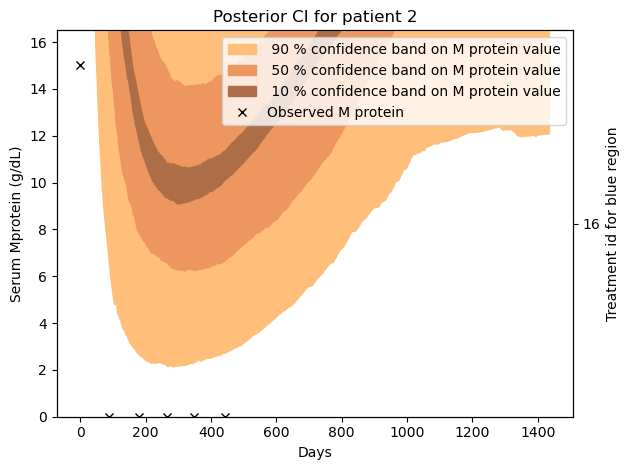

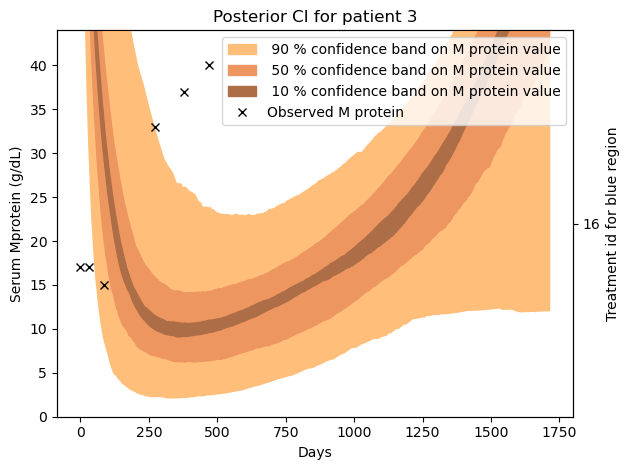

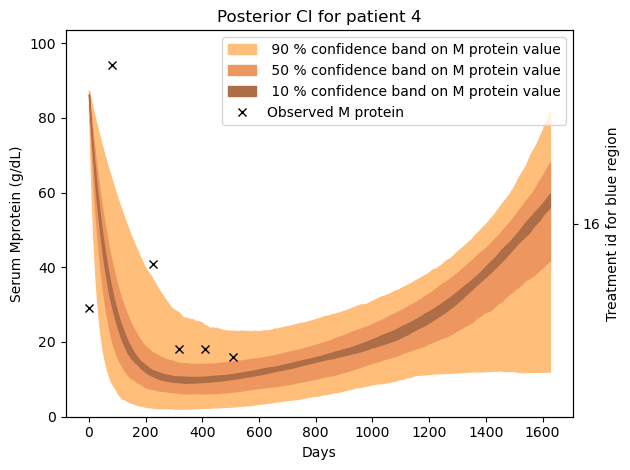

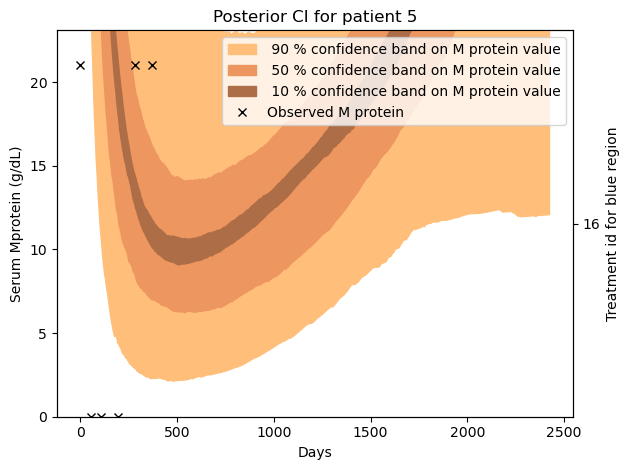

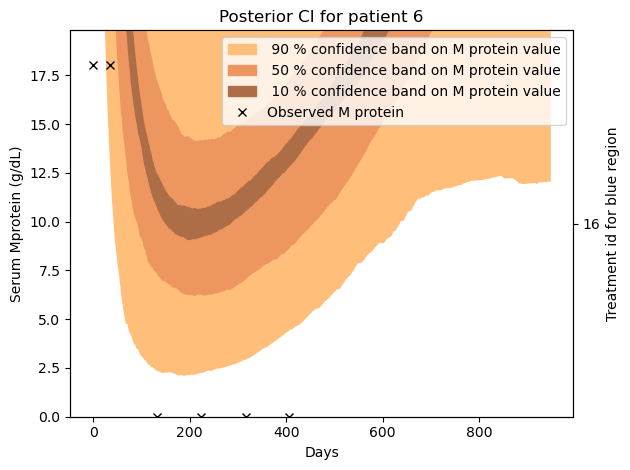

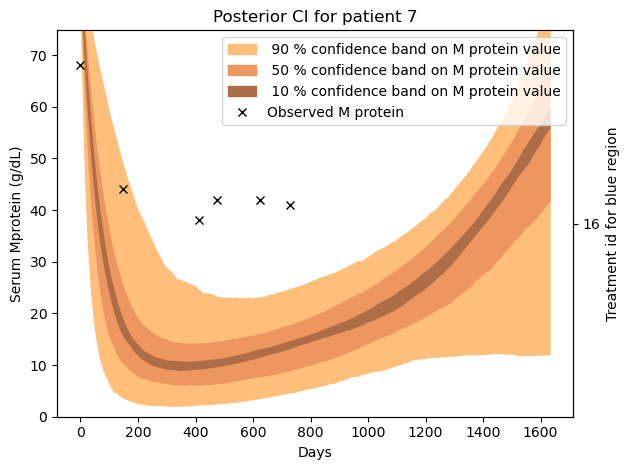

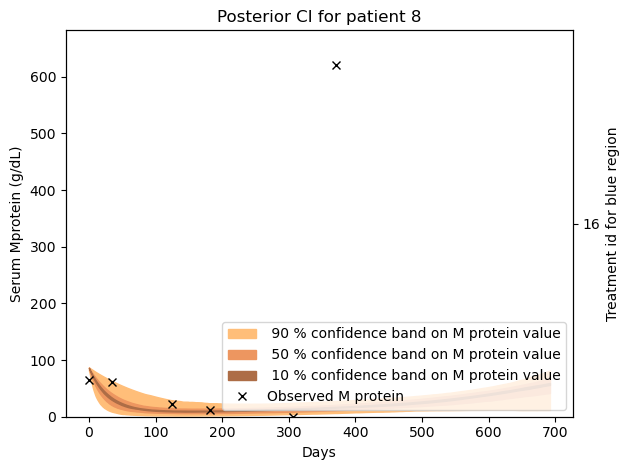

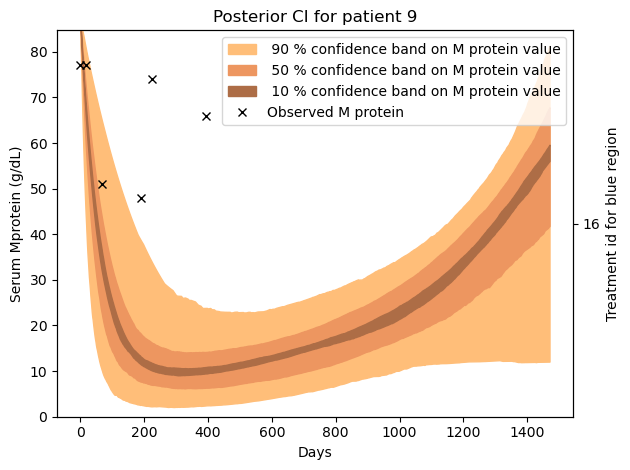

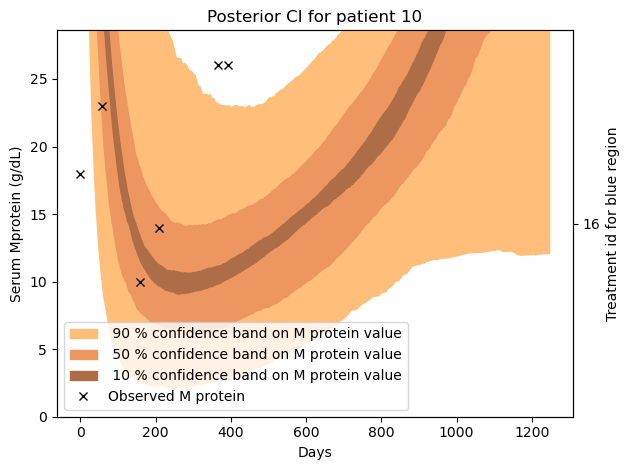

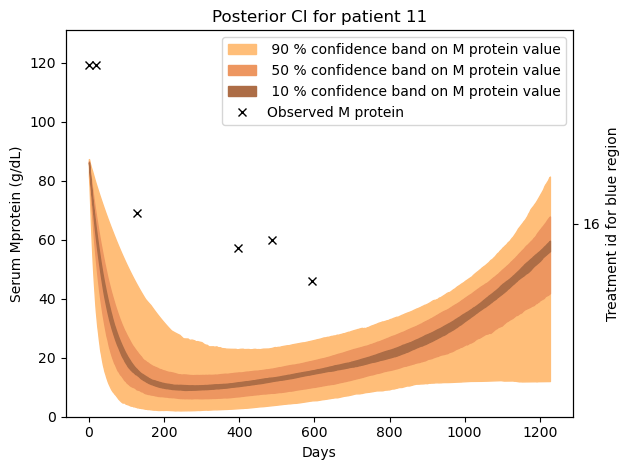

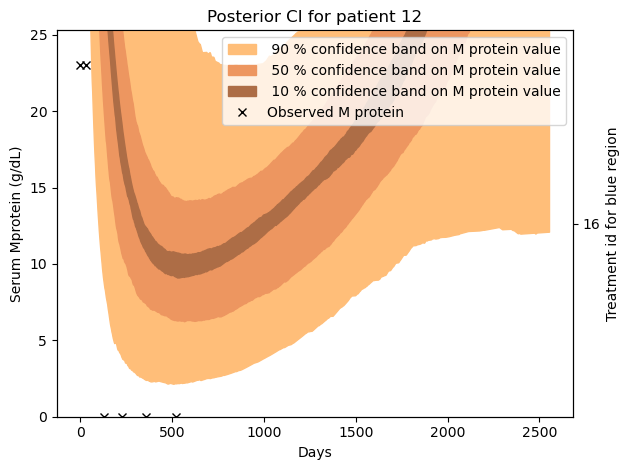

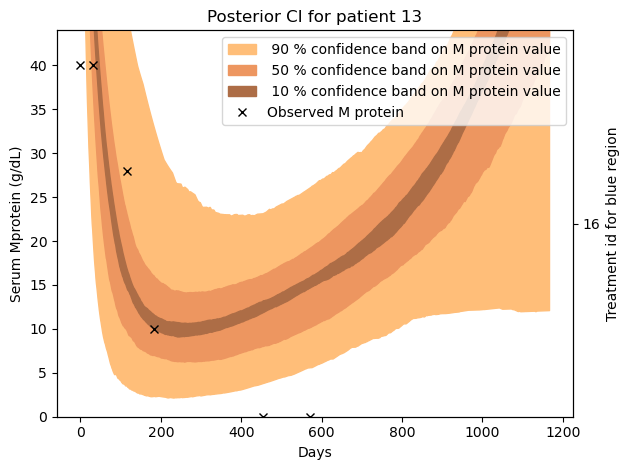

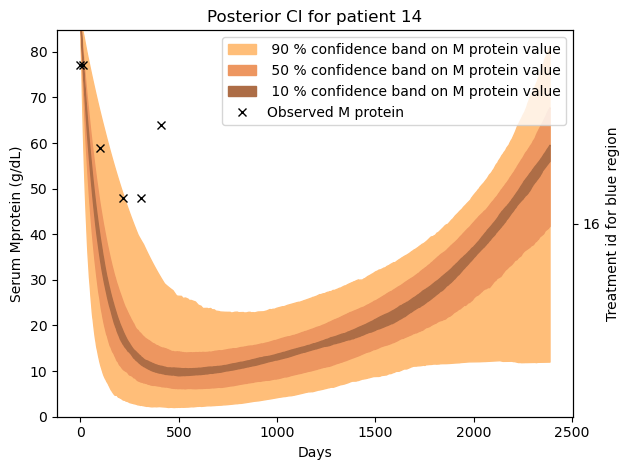

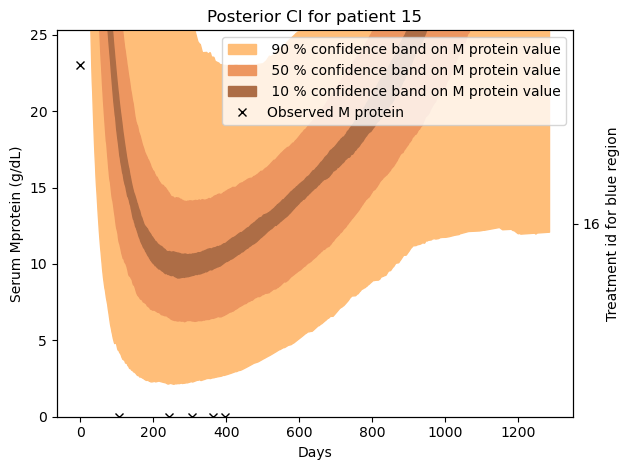

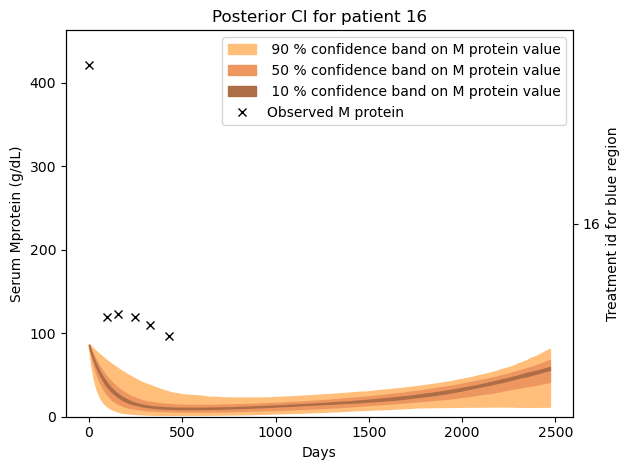

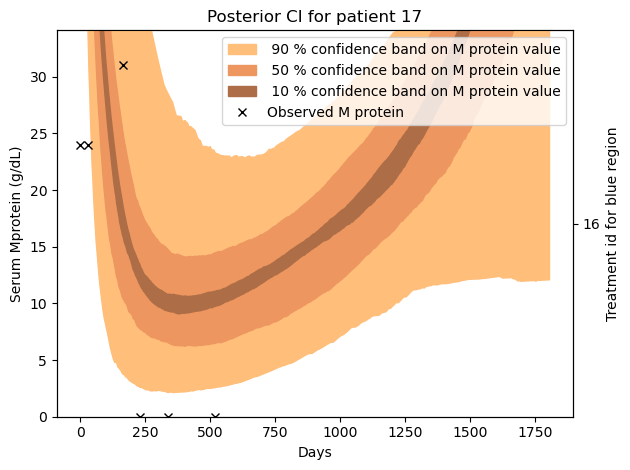

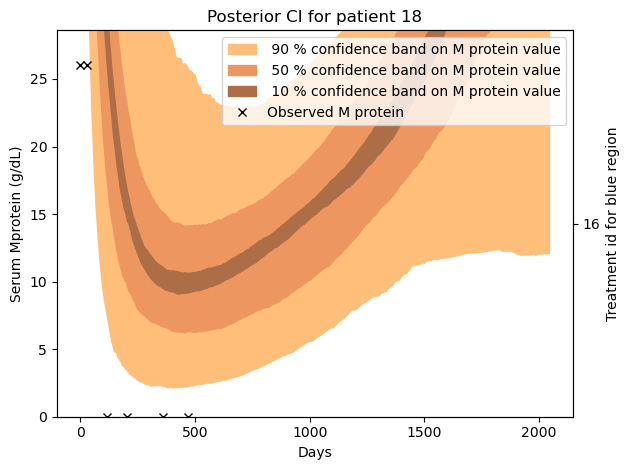

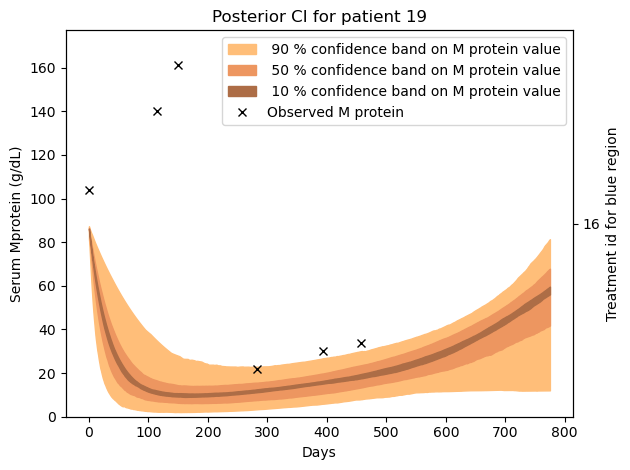

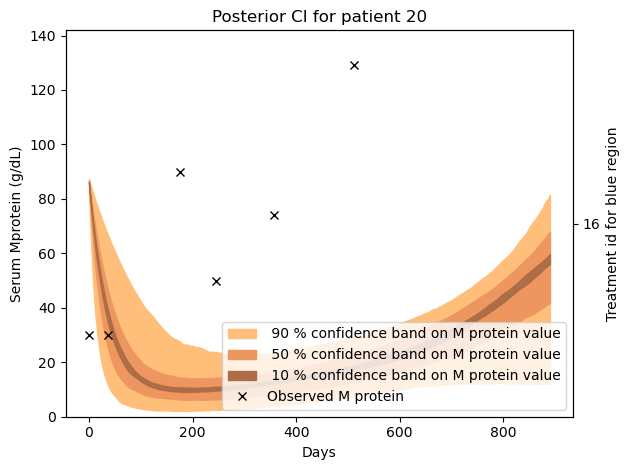

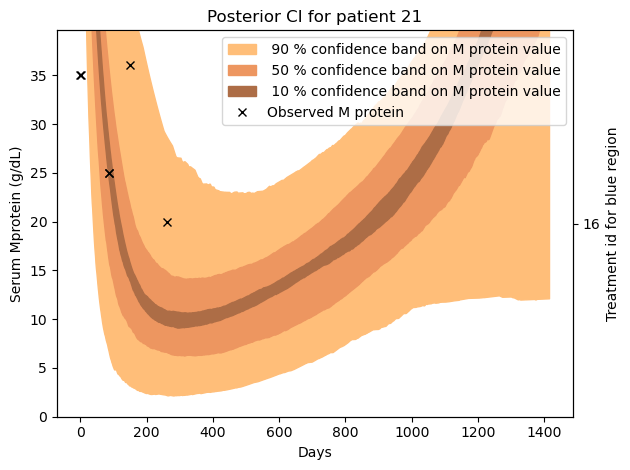

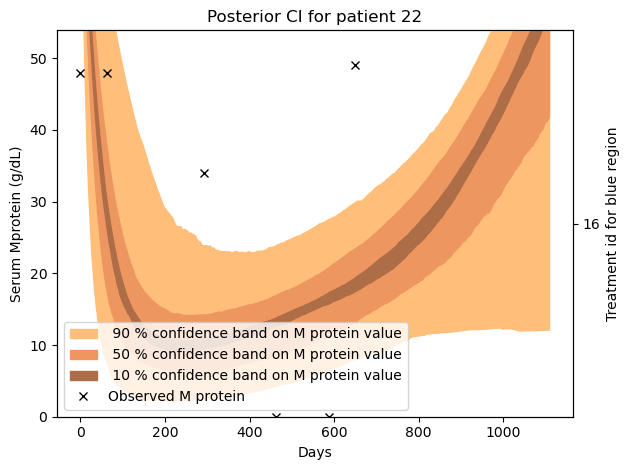

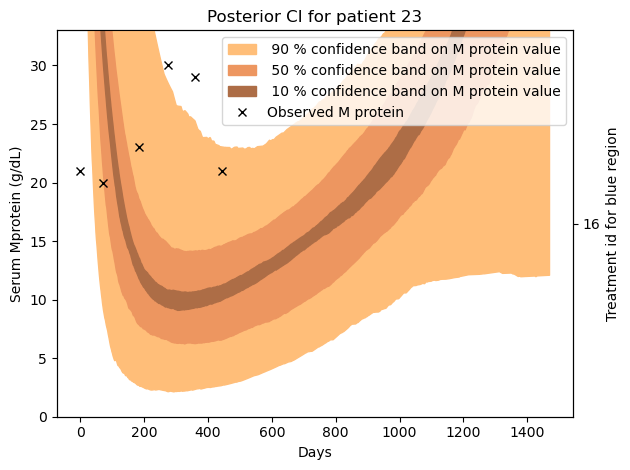

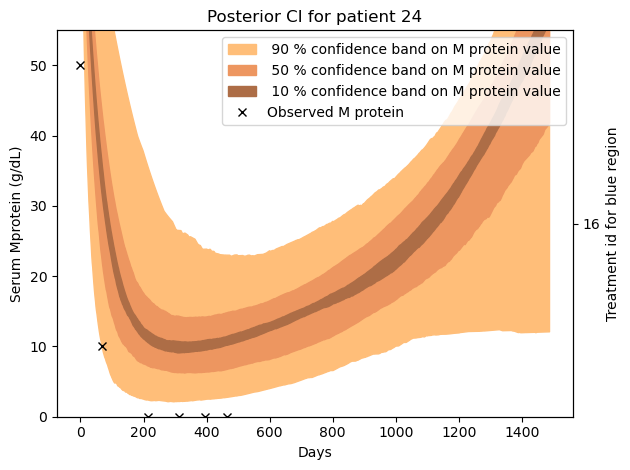

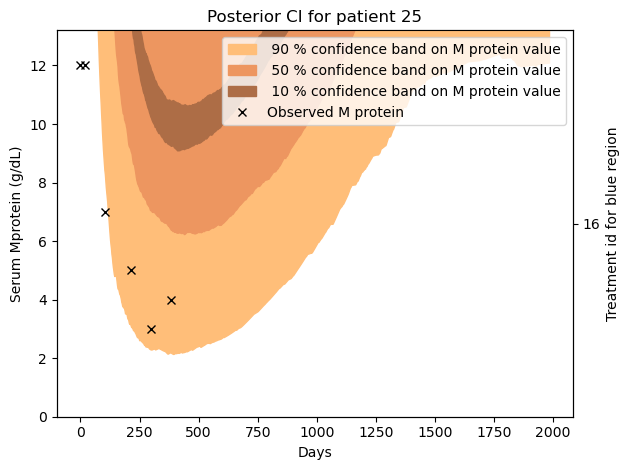

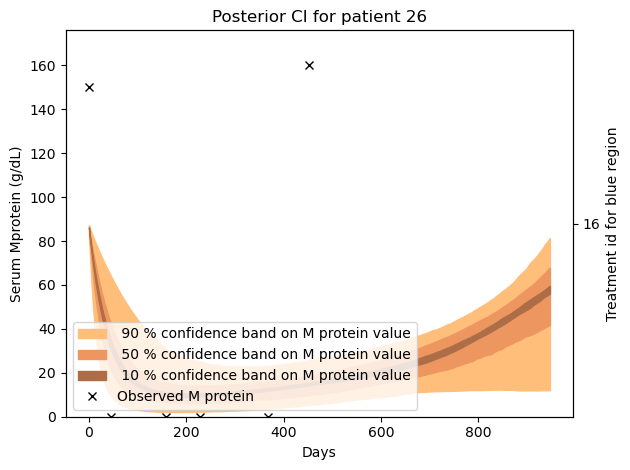

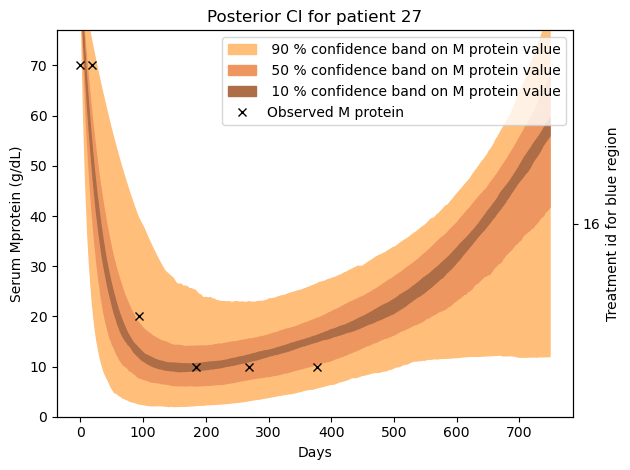

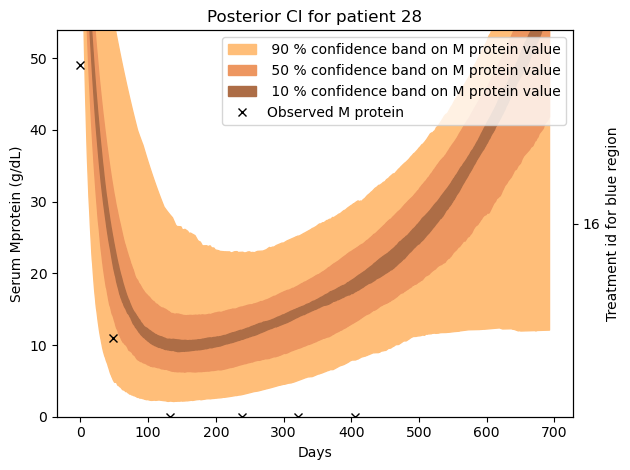

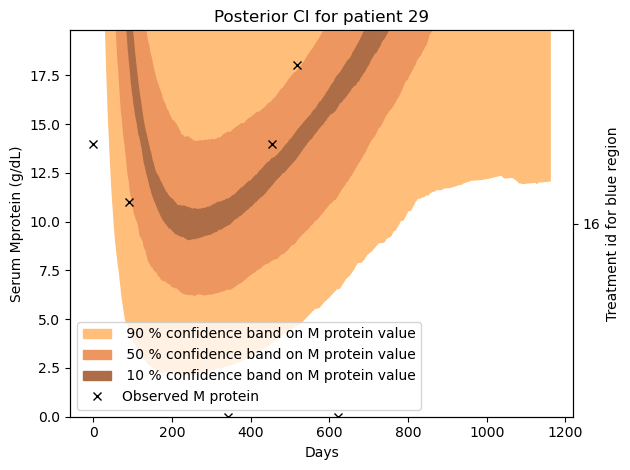

In [90]:
# Plot posterior confidence intervals 
def plot_posterior_confidence_intervals(patient, sorted_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="", savename="0", y_resolution=1000):
    measurement_times = patient.get_measurement_times()
    treatment_history = patient.get_treatment_history()
    Mprotein_values = patient.get_Mprotein_values()
    time_zero = min(treatment_history[0].start, measurement_times[0])
    time_max = max(treatment_history[-1].end, int(measurement_times[-1]))
    plotting_times = np.linspace(time_zero, time_max, y_resolution)
    
    fig, ax1 = plt.subplots()
    ax1.patch.set_facecolor('none')

    if PLOT_POINT_ESTIMATES:
        # Plot true M protein values according to parameter estimates
        plotting_mprotein_values = measure_Mprotein_noiseless(parameter_estimates, plotting_times, treatment_history)
        # Count resistant part
        resistant_parameters = Parameters((parameter_estimates.Y_0*parameter_estimates.pi_r), 1, parameter_estimates.g_r, parameter_estimates.g_s, parameter_estimates.k_1, parameter_estimates.sigma)
        plotting_resistant_mprotein_values = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)
        # Plot resistant M protein
        ax1.plot(plotting_times, plotting_resistant_mprotein_values, linestyle='-', marker='', zorder=3, color='r', label="Estimated M protein (resistant)")
        # Plot total M protein
        ax1.plot(plotting_times, plotting_mprotein_values, linestyle='--', marker='', zorder=3, color='k', label="Estimated M protein (total)")

    # Plot posterior confidence intervals 
    # 95 % empirical confidence interval
    color_array = ["#fbd1b4", "#f89856", "#e36209"] #["#fbd1b4", "#fab858", "#f89856", "#f67c27", "#e36209"] #https://icolorpalette.com/color/rust-orange
    for index, confidence_level in enumerate([0.05, 0.25, 0.45]):
        # Get index to find right value 
        lower_index = int(confidence_level*n_chains*n_samples)
        upper_index = int((1-confidence_level)*n_chains*n_samples)
        # index at intervals to get 95 % limit value
        lower_limits = sorted_pred_y_values[lower_index,ii,:]
        upper_limits = sorted_pred_y_values[upper_index,ii,:]       #color=color_array[index]
        ax1.fill_between(plotting_times, lower_limits, upper_limits, color=plt.cm.copper(1-confidence_level), label='%3.0f %% confidence band on M protein value' % (100*(1-2*confidence_level)))

    # Plot M protein observations
    ax1.plot(measurement_times, Mprotein_values, linestyle='', marker='x', zorder=3, color='k', label="Observed M protein") #[ax1.axvline(time, color="k", linewidth=0.5, linestyle="-") for time in measurement_times]

    # Plot treatments
    plotheight = 1
    maxdrugkey = 0
    ax2 = ax1.twinx() 
    for treat_index in range(len(treatment_history)):
        this_treatment = treatment_history[treat_index]
        if this_treatment.id != 0:
            treatment_duration = this_treatment.end - this_treatment.start
            if this_treatment.id > maxdrugkey:
                maxdrugkey = this_treatment.id
            if PLOT_TREATMENTS:
                ax2.add_patch(Rectangle((this_treatment.start, this_treatment.id - plotheight/2), treatment_duration, plotheight, zorder=2, color="lightskyblue")) #color=treat_colordict[treat_line_id]))

    ax1.set_title(plot_title)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Serum Mprotein (g/dL)")
    ax1.set_ylim(bottom=0, top=(1.1*max(Mprotein_values)))
    #ax1.set_xlim(left=time_zero)
    ax2.set_ylabel("Treatment id for blue region")
    ax2.set_yticks([maxdrugkey])
    ax2.set_yticklabels([maxdrugkey])
    ax2.set_ylim(bottom=maxdrugkey-plotheight, top=maxdrugkey+plotheight)
    #ax2.set_ylim([-0.5,len(unique_drugs)+0.5]) # If you want to cover all unique drugs
    ax1.set_zorder(ax1.get_zorder()+3)
    ax1.legend()
    #ax2.legend() # For drugs, no handles with labels found to put in legend.
    fig.tight_layout()
    plt.savefig(savename)
    plt.show()
    plt.close()

for training_instance_id, patient in patient_dictionary.items():
    savename = "./plots/Bayesian_estimates/CI_training_id_"+str(training_instance_id)+"_treat_id"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+".png"
    plot_posterior_confidence_intervals(patient, sorted_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior CI for patient "+str(training_instance_id), savename=savename, y_resolution=y_resolution)



In [ ]:
# Posterior median M protein 
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print("Median sigma_obs:", median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print("First patient's median parameters:", estimated_parameters_dict[0].to_array_with_sigma())

# Plot patient estimates
for training_instance_id, patient in patient_dictionary.items():
    estimated_parameters = estimated_parameters_dict[training_instance_id]
    #patient.print()
    savename = "./plots/Bayesian_estimates/training_id_"+str(training_instance_id)+"_treat_id"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_median_parameters__Y_0="+str(estimated_parameters.Y_0)+", pi_r="+str(estimated_parameters.pi_r)+", g_r="+str(estimated_parameters.g_r)+", g_s="+str(estimated_parameters.g_s)+", k_1="+str(estimated_parameters.k_1)+", sigma="+str(estimated_parameters.sigma)+".png"
    plot_treatment_region_with_estimate(estimated_parameters, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Posterior median for "+str(training_instance_id), savename=savename)
